# Case Study: Forecasting  
*Author: S.A. Klop*  

In this case study, we demonstrate the different ways a time series model can be used for forecasting. The case is divided into two parts. In the first part, we explore how a time series model can be used to investigate what the groundwater level might do after switching off a pumping station. The second part describes a longer-term forecast.

## Table of Contents

- [Part I: Shutting Down Abstraction](#part-i-shutting-down-abstraction)  
    - [Available Data](#available-data-example-1)  
    - [Preprocessing Time Series](#preprocessing-time-series-example-1)  
    - [Building the Time Series Model](#building-the-time-series-model)  
    - [Forecasting the Groundwater Head](#forecasting-the-groundwater-head)  
    - [Forecast Verification](#forecast-verification)  

- [Part II: Recovery of Groundwater Head](#part-ii-groundwater-head-recovery-in-april)  
    - [Available Data](#available-data-example-2)  
    - [Setting Up the Time Series Model](#setting-up-the-time-series-model)  
    - [Forecasting Precipitation Surplus](#forecasting-precipitation-surplus)  
    - [Forecasting Groundwater Head](#forecasting-groundwater-head)  


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML
import datetime

import pastas as ps

%matplotlib inline
ps.set_log_level("ERROR")

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

## Part I: Shutting Down Abstraction

The water authority has measured the groundwater head at Observation Well 1. In the vicinity of this well, there is a groundwater abstraction. On August 1, 2012, the abstraction was shut down, and the extracted flow rate was reduced to 0 m³/day. A consultancy firm was asked to determine the expected rise in groundwater head at the location of Observation Well 1 as a result of shutting down this abstraction. Data is available up to July 31, 2012.

### Available Data Example 1

The measured groundwater head is shown in the figure below. The measurement period spans from 1995 to 2020. The time series contains some values that do not fit the pattern. Therefore, it is necessary to preprocess the time series before it can be applied in the time series model.

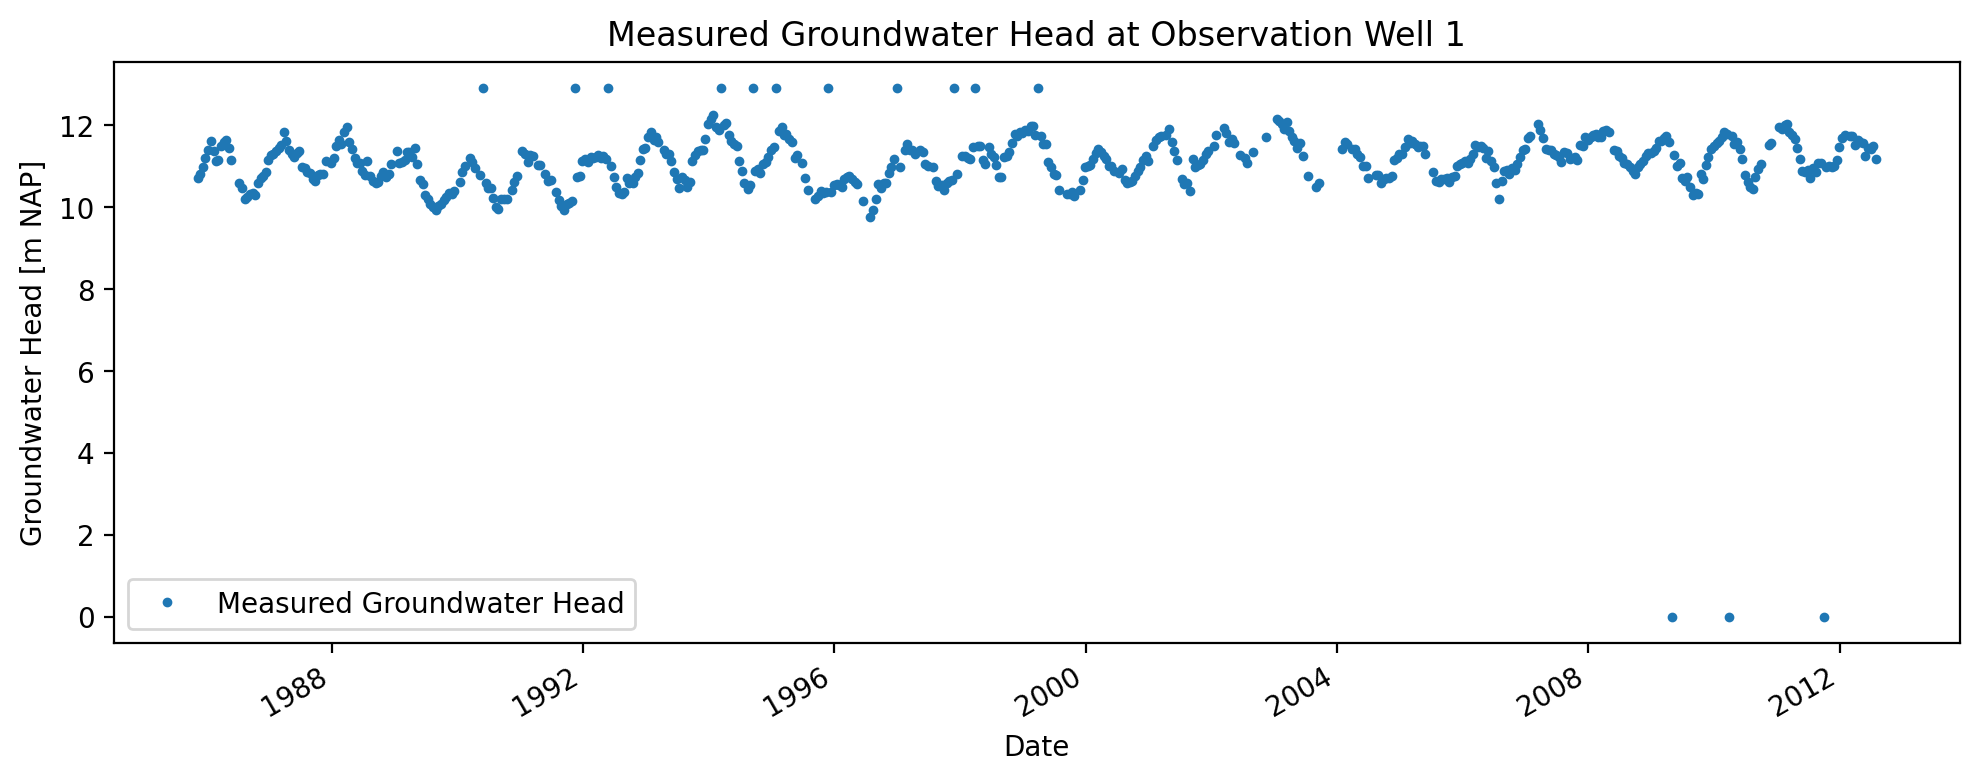

In [2]:
# Load the groundwater head data
gws = pd.read_csv("data/stijghoogte_onttrekking_edit.csv", index_col=0, parse_dates=True)

# Plot the groundwater head
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws.loc[:'2012-08-01'].plot(ax=ax, color='C0', linestyle='', marker='.', markersize=5)

# Format the figure
ax.set_ylabel('Groundwater Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head at Observation Well 1')
ax.legend(['Measured Groundwater Head'])

plt.tight_layout()
plt.show()

To build a time series model for the groundwater head measurements, precipitation and evaporation data are used. For this purpose, data from the nearest KNMI weather station were used. The measured precipitation and evaporation are shown in the figure below.

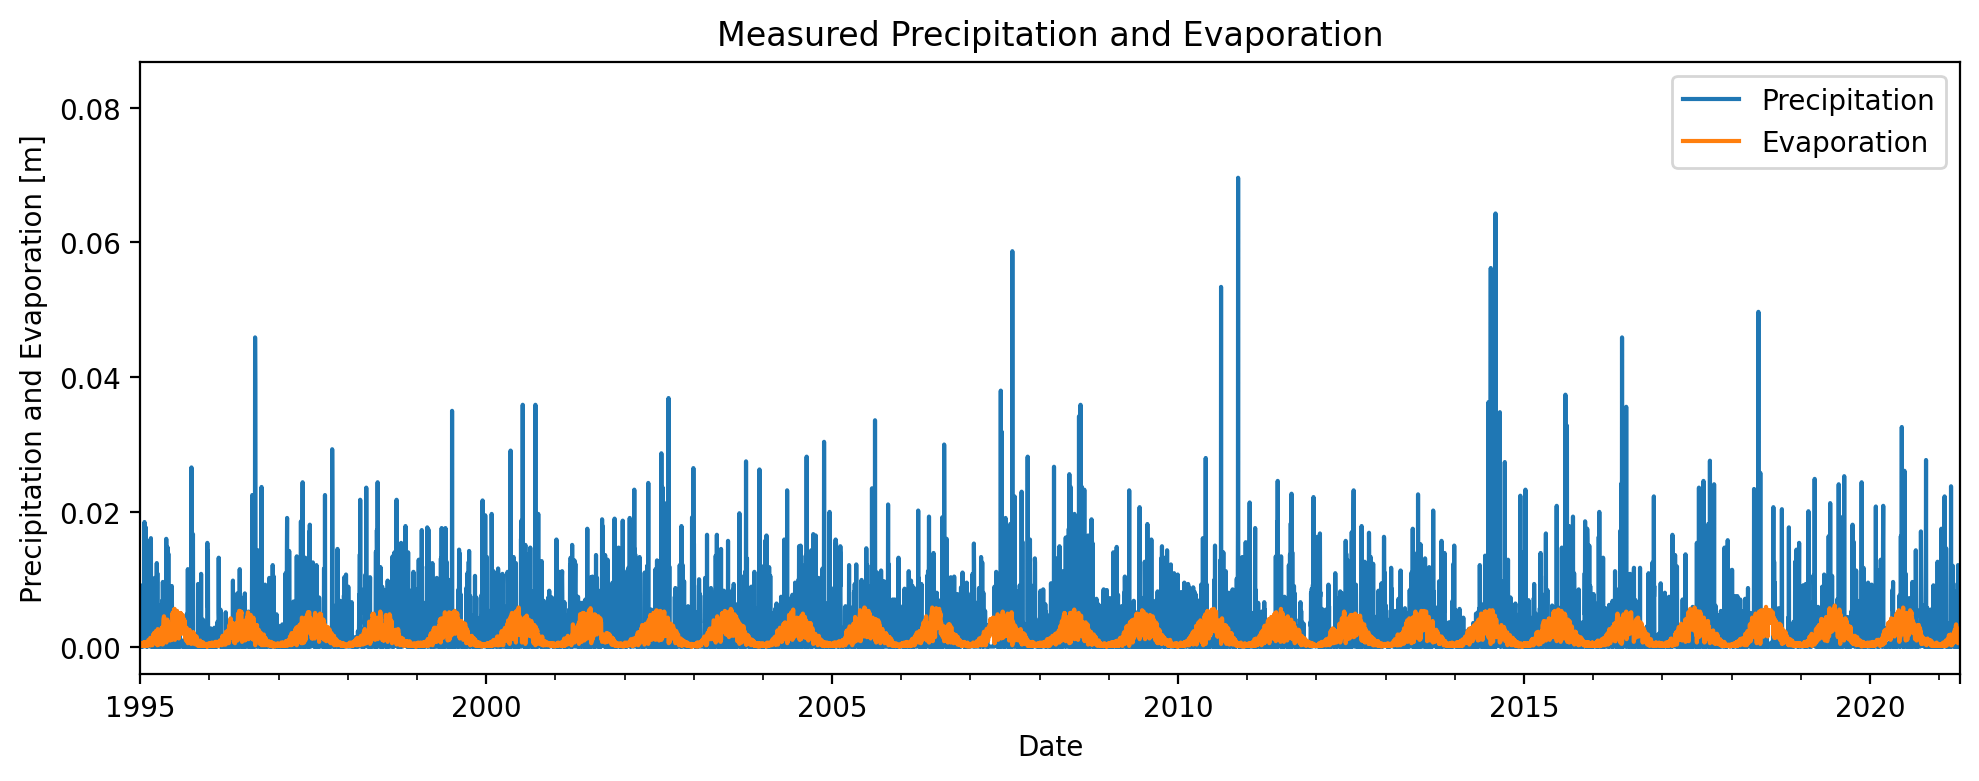

In [3]:
precipitation = pd.read_csv("data/neerslag_onttrekking.csv",
                       index_col=0, parse_dates=True)
precipitation.columns = ['precipitation']
evaporation = pd.read_csv("data/verdamping_onttrekking.csv",
                         index_col=0, parse_dates=True)
evaporation.columns = ['evaporation']

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
precipitation.plot(ax=ax, color='C0')
evaporation.plot(ax=ax, color='C1')

# Format the figure
ax.set_ylabel('Precipitation and Evaporation [m]')
ax.set_xlabel('Date')
ax.set_title('Measured Precipitation and Evaporation')
ax.legend(['Precipitation', 'Evaporation'])
ax.set_xlim(xmin='1995')

plt.tight_layout()
plt.show()

In addition to precipitation and evaporation, the abstraction data was also used as an explanatory series in the time series model. For this purpose, the daily discharge was requested from the operator of the abstraction. This is shown in the figure below. It also shows that the abstraction was completely phased out in 2012. Before that period, the discharge varied between approximately 5,000 and 12,000 m³/day.

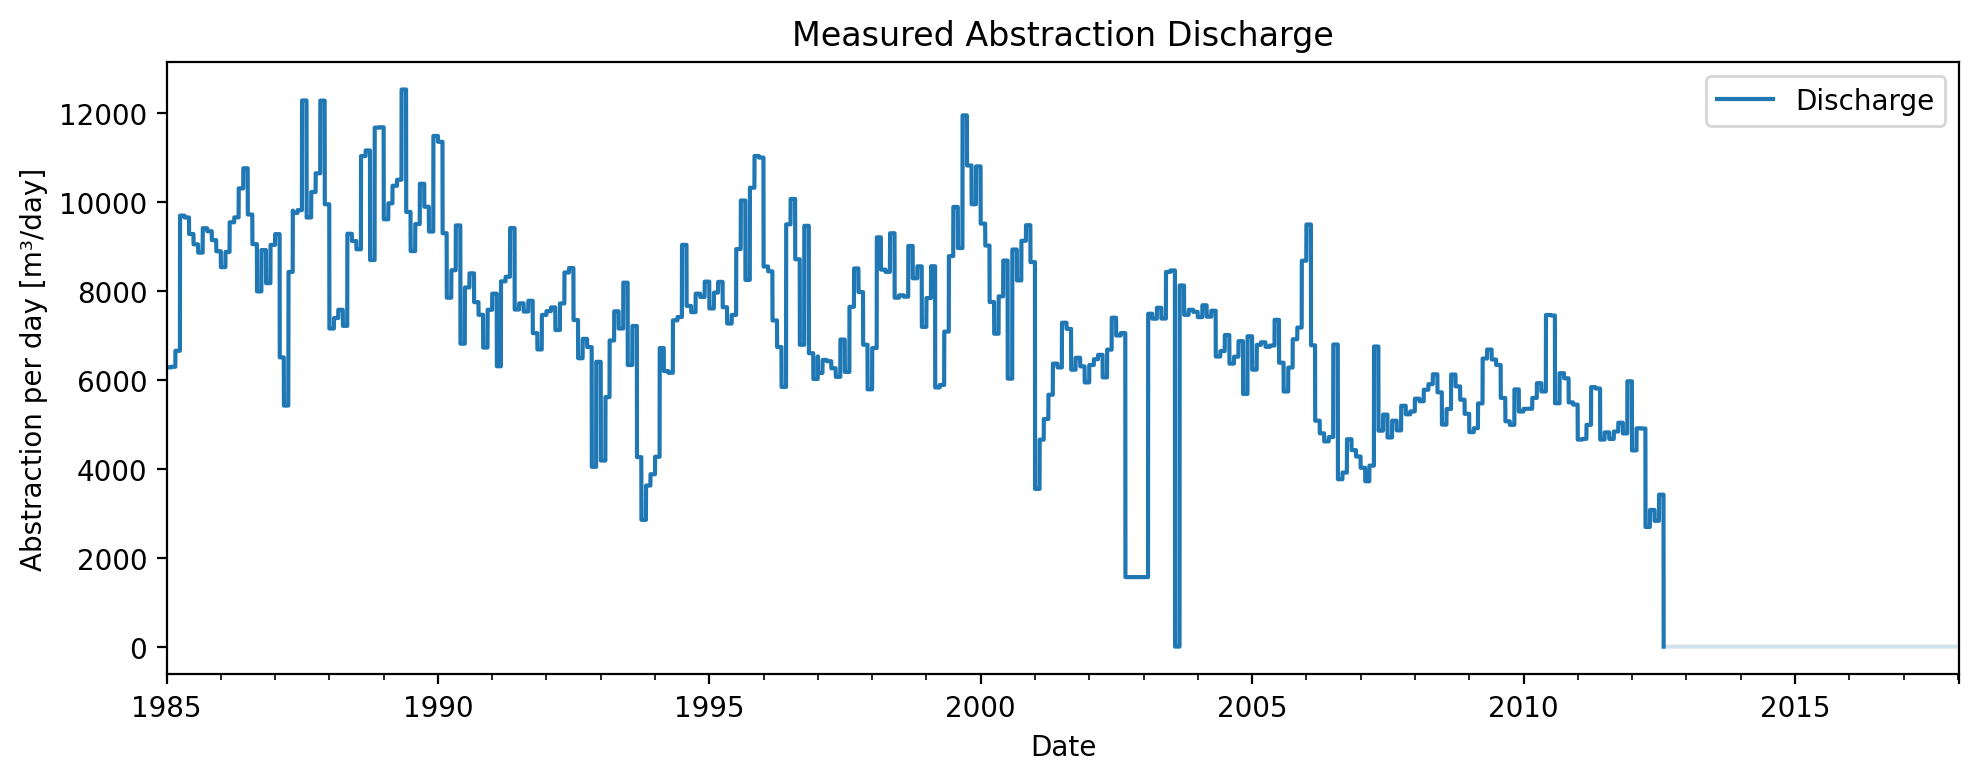

In [4]:
abstraction = pd.read_csv("data/debiet_onttrekking.csv", index_col="Date", parse_dates=True)

# Plot the abstraction data
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
abstraction.loc[:'2012-08-01'].plot(ax=ax, color='C0')
abstraction.loc['2012-08-01':].plot(ax=ax, color='C0', alpha=0.2)

# Format the figure
ax.set_ylabel('Abstraction per day [m³/day]')
ax.set_xlabel('Date')
ax.set_title('Measured Abstraction Discharge')
ax.legend(['Discharge'])

plt.tight_layout()
plt.show()

### Preprocessing Time Series Example 1

As seen in the groundwater head time series, the dataset contains several zero values. These values may be the result of sensor errors or issues during data retrieval. To make the series suitable for time series analysis, it must first be preprocessed.

The measurements with a value of zero are removed from the series before it is used in the time series model. The gaps left by the removed values are not filled in but left as missing.


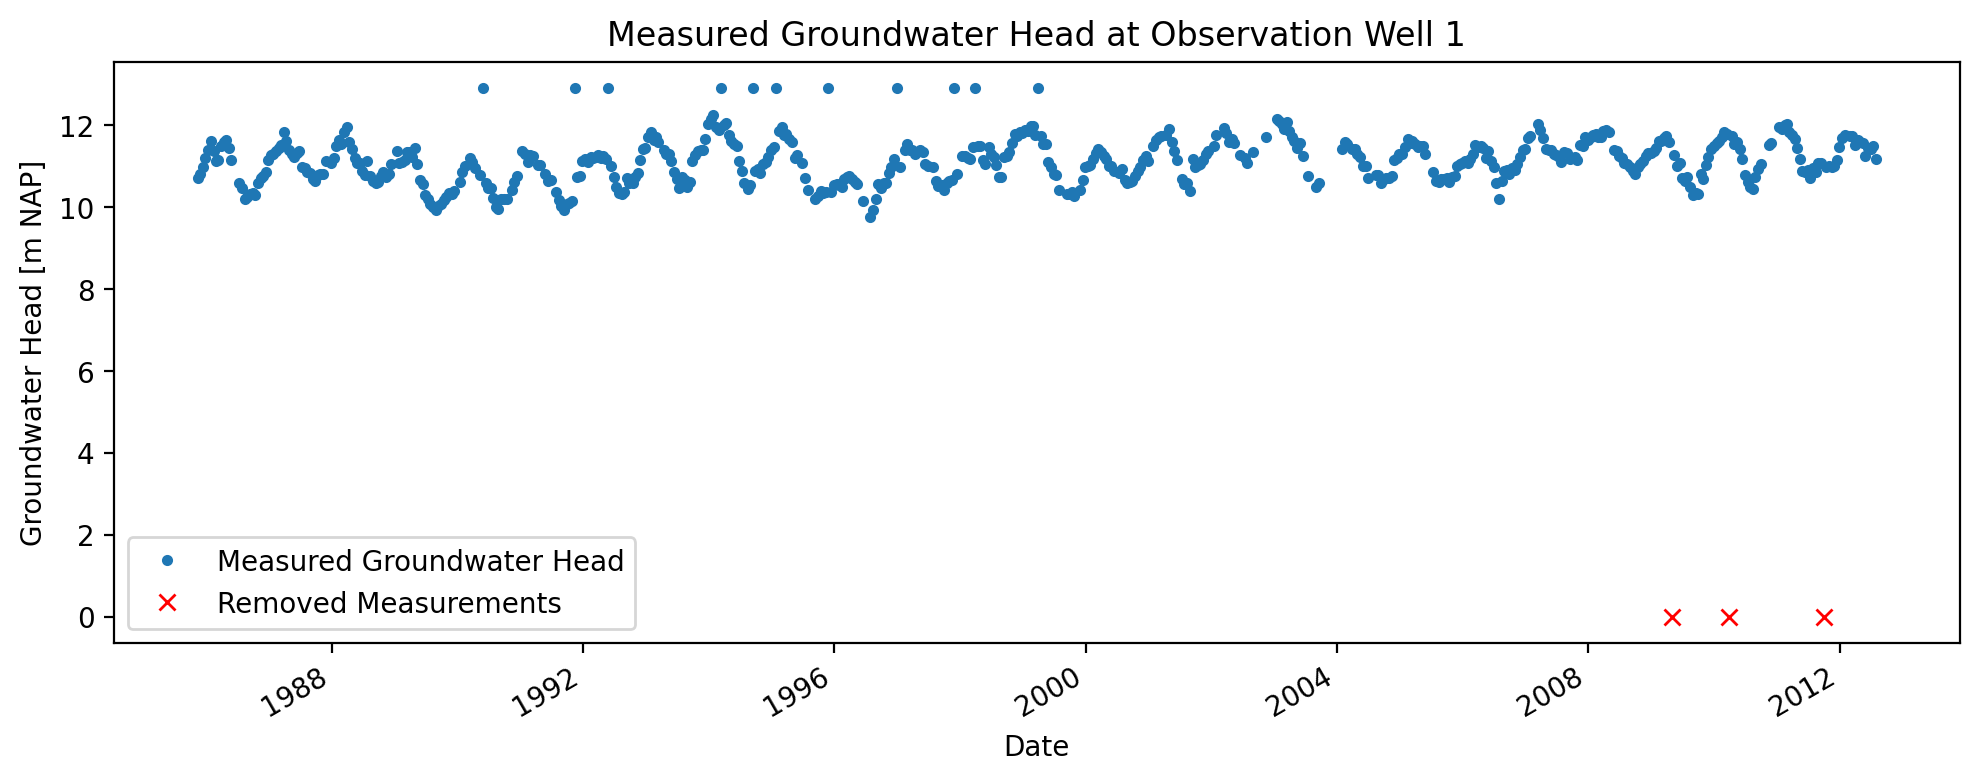

In [5]:
gws_removed = gws[gws == 0]

# Remove measurements with value 0 from the series
gws_cleaned = gws[gws != 0]

# Plot the groundwater head
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws_cleaned.loc[:'2012-08-01'].plot(ax=ax, color='C0', linestyle='', marker='.')
gws_removed.loc[:'2012-08-01'].plot(ax=ax, color='red', linestyle='', marker='x', label='Removed Values')

# Format the figure
ax.set_ylabel('Groundwater Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head at Observation Well 1')
ax.legend(['Measured Groundwater Head', 'Removed Measurements'])

plt.tight_layout()
plt.show()

### Building the Time Series Model

The first step in building the model is to add the groundwater head observations to the model. For an initial calculation, the groundwater head series is used up to the current date.

Precipitation and evaporation are used as explanatory series. A response function is chosen for each explanatory series. The response function describes how the groundwater head reacts to an external influence. This must be determined for each explanatory variable, where the user selects the type of response function and the parameters of the function are optimized. For the time series model, the Gamma response function is chosen for both precipitation and evaporation.

The same response function is used for both precipitation and evaporation in the time series model. The relationship between precipitation and evaporation is described by the formula  
$R = P - f \cdot E$,  
where *R* is the groundwater recharge [m], *P* is the precipitation [m], *f* is the evaporation factor [-], and *E* is the evaporation [m]. The evaporation factor is optimized by the time series model together with the three parameters of the Gamma response function.

The abstraction is also used as an explanatory series in the time series model. For this series, the Hantush response function is selected. In addition to the explanatory variables, the constant (denoted as *d* in the time series model) is also optimized.

After adding the observations and explanatory series, the time series model can be optimized. The results of the time series model are shown in the table below.


In [6]:
ml = ps.Model(gws_cleaned[:'2012-08-01'])
sm1 = ps.RechargeModel(precipitation, evaporation, rfunc=ps.Gamma(), name='gwa')


sm2 = ps.StressModel(stress=abstraction, rfunc=ps.Hantush(),
                     name='abstraction', settings='well', up=False)
ml.add_stressmodel([sm1, sm2])

ml.solve(report=False)


gws_simulatie1 = ml.simulate()

Once the time series model has been optimized, the simulated series can be plotted. This is shown in the figure below, along with an overview of the model results.

In the figure, the measurements and the simulation are visually displayed. Below that, the model residuals and noise are shown. For the different explanatory series, the contributions are displayed along with their respective response functions. These are the Gamma response functions as optimized by the time series model.

Additionally, a table is included in the figure showing the optimized parameters along with their corresponding standard deviations. This also includes the optimized constant and evaporation factor, for example.


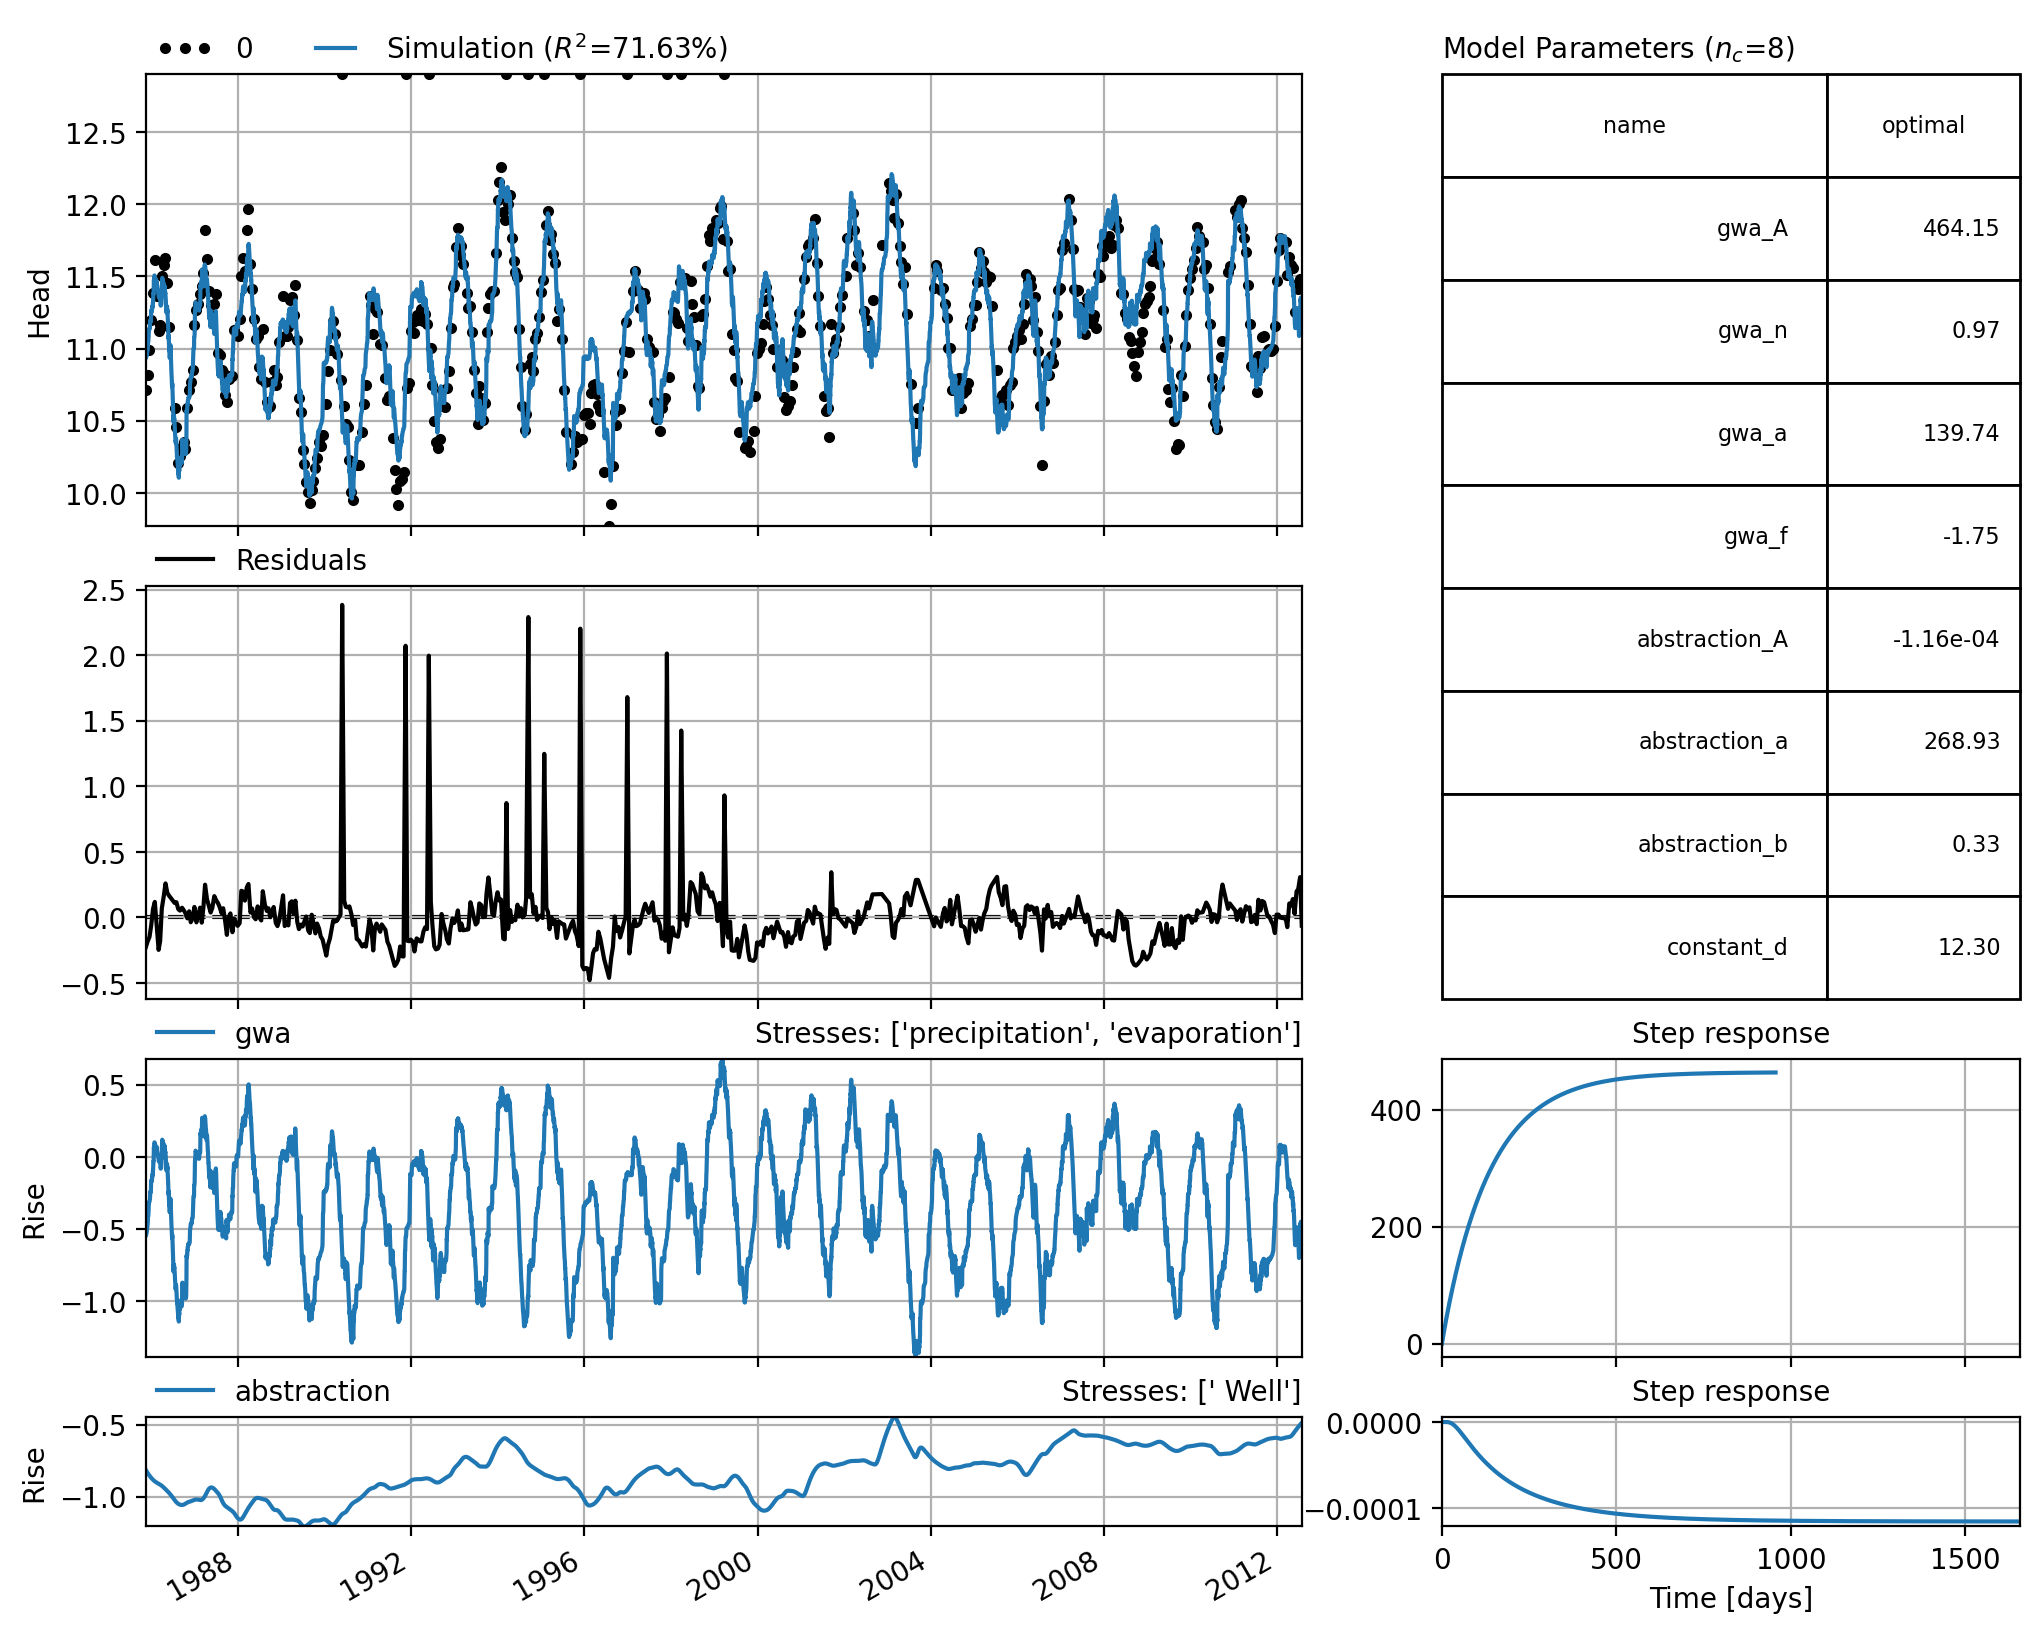

In [7]:
ml.plots.results(figsize=(10, 8));

The results of the model show that the time series model is not able to accurately simulate the outliers in the measurement series. After consultation with the manager of the area where Observation Well 1 is located, it was found that the measurements above +12.8 m NAP are unrealistic and do not match field observations. It is possible that the well overflowed during those days, resulting in higher recorded values.

These outliers may negatively affect the performance of the time series model, as they cannot be explained using the explanatory series included in the model. Therefore, the time series model is rebuilt using only groundwater head measurements below +12.8 m NAP.


In [8]:

mv = 12.8
ml2 = ps.Model(gws_cleaned[gws_cleaned < mv][:'2012-08-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(precipitation, evaporation, rfunc=ps.Gamma(), name='gwa')

# toevoegen van onttrekking als verklarende reeks
sm2 = ps.StressModel(stress=abstraction, rfunc=ps.Hantush(),
                     name='abstraction', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml2.solve(report=False)

# simuleren van de stijghoogte
gws_simulatie2 = ml2.simulate()

The results of the new time series model are shown in the figure below.

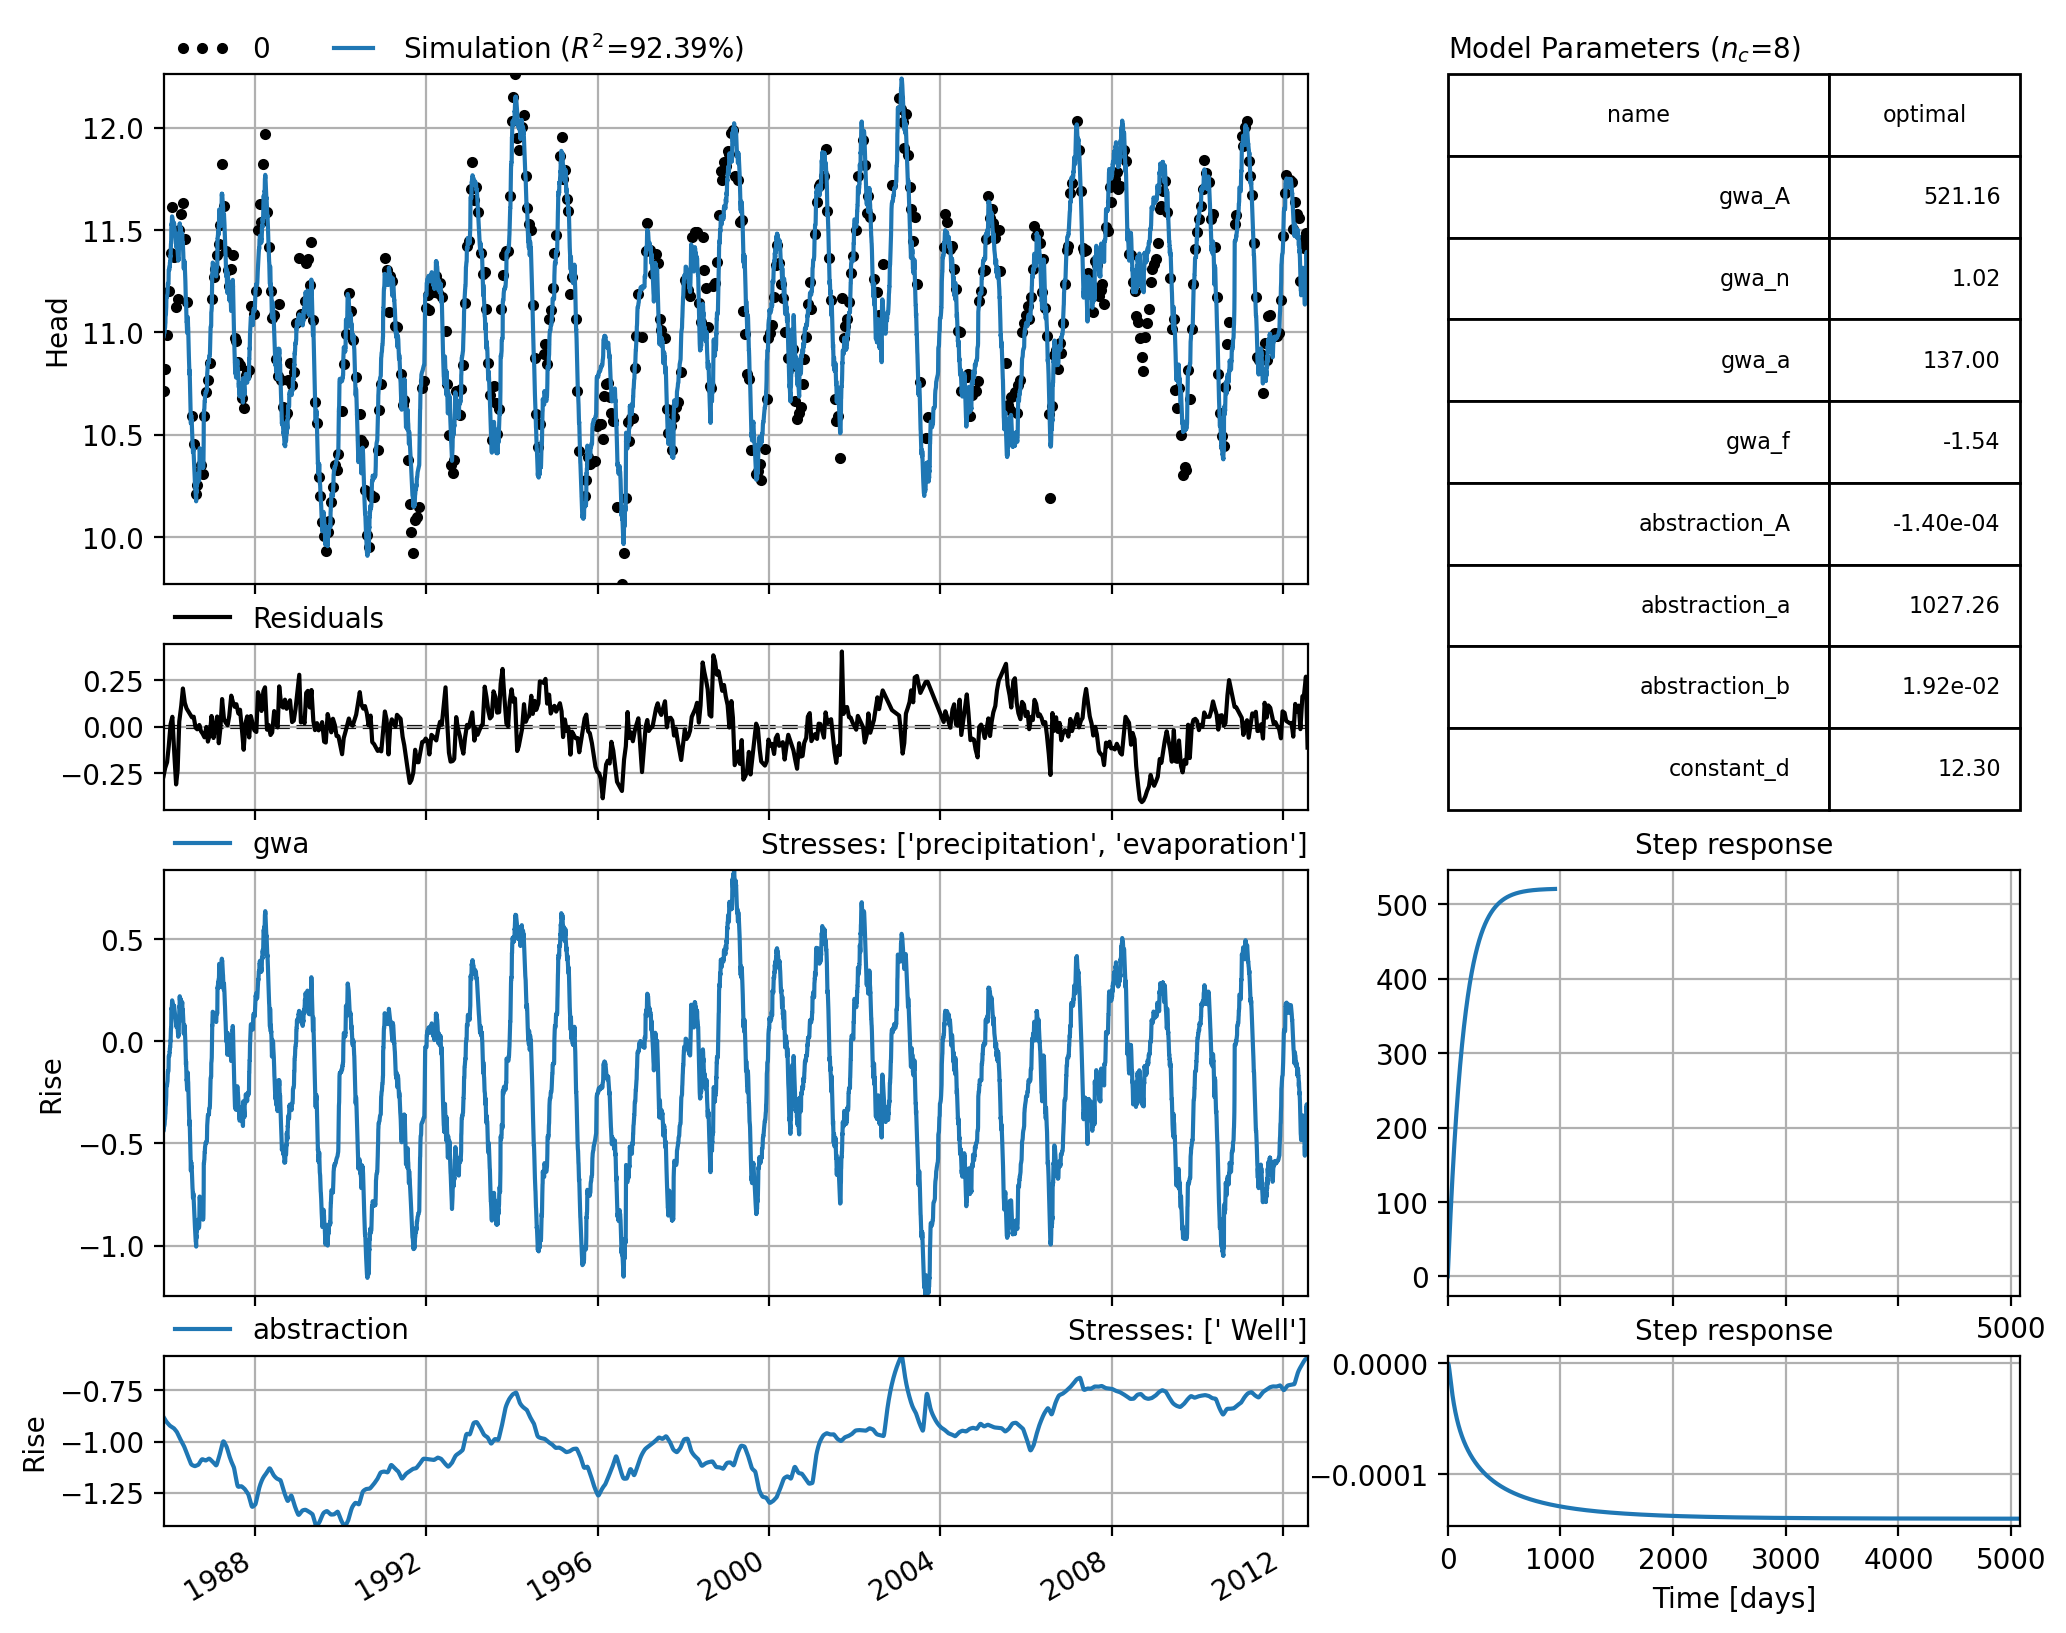

In [9]:
ml2.plots.results(figsize=(10, 8));

The second time series model, in which measurements above 17 m NAP were excluded, shows a higher explained variance and R², and a lower root mean square error (RMSE). In the figure below, the simulated groundwater head series from the new time series model (without outliers and unrealistic measurements) is compared to the first time series model. Based on visual inspection, it is not immediately clear which model performs better, as their performance appears similar to the eye.

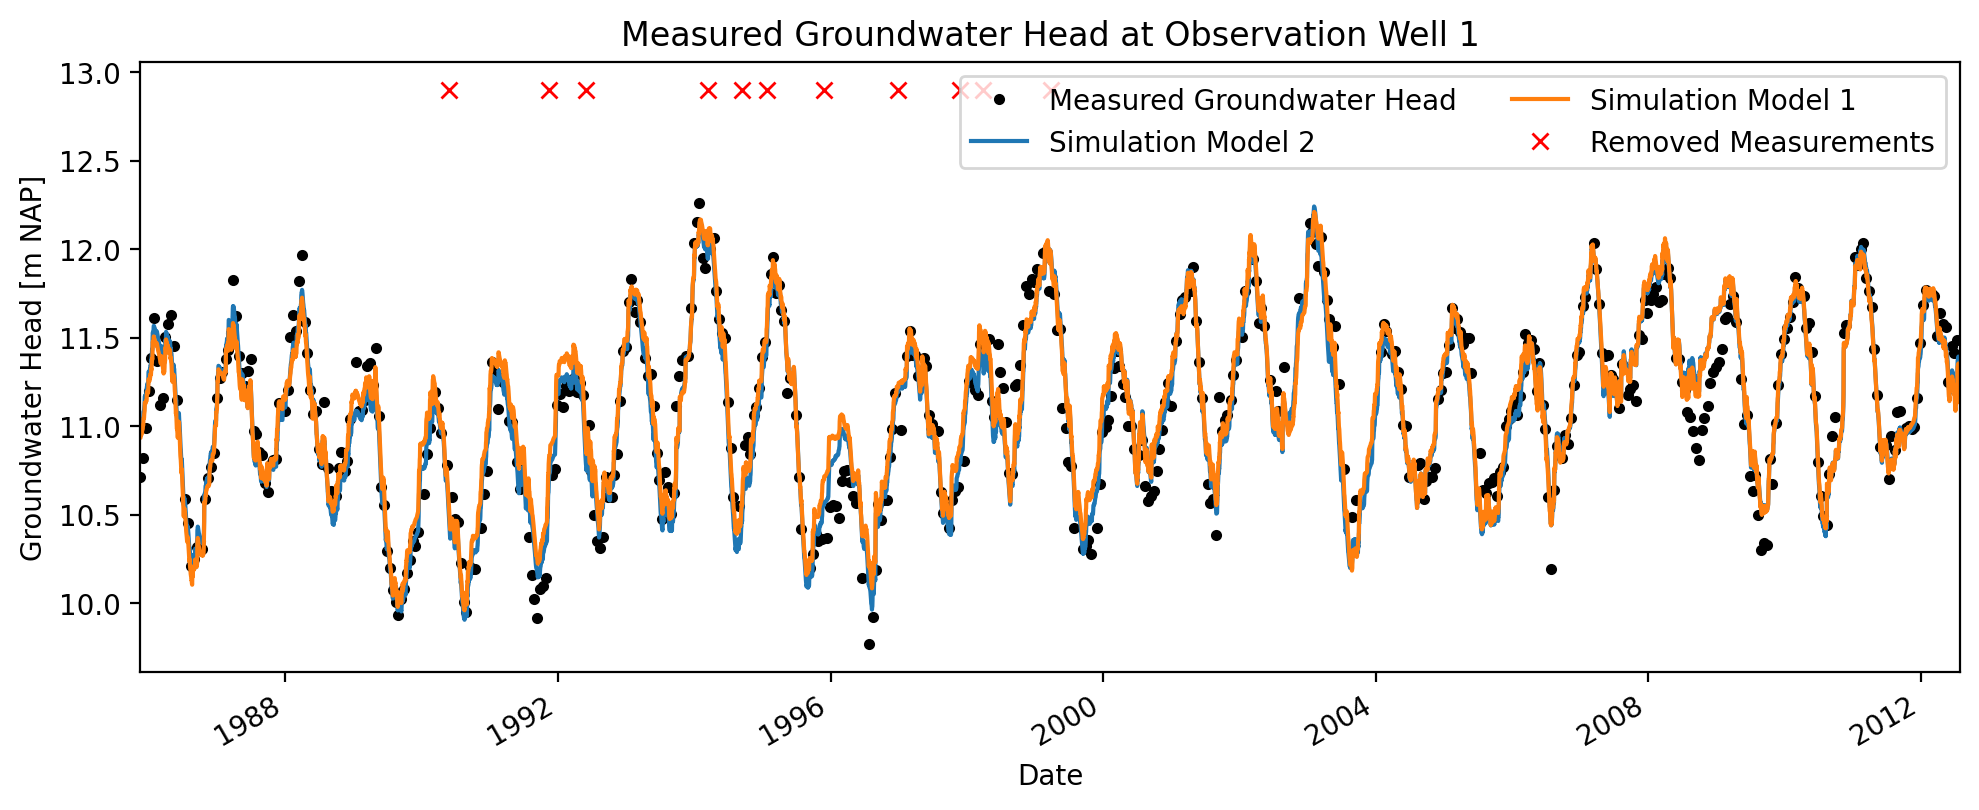

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ml2.plot(ax=ax)
gws_simulatie1.plot(ax=ax)


ax.plot(gws_cleaned[gws_cleaned > mv], marker='x', linestyle='', color='r')


ax.set_ylabel('Groundwater Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head at Observation Well 1')
ax.legend(['Measured Groundwater Head', 'Simulation Model 2',
           'Simulation Model 1', 'Removed Measurements'], ncol=2)


Initially, the Gamma and Hantush response functions were chosen for the explanatory series. It is up to the modeler to decide which response function to use. Therefore, the model is built again using different response functions for comparison. For both explanatory series, the following response functions are tested: Exponential, Gamma, and Hantush.

The tables below show the R² and RMSE values for the models. The rows of the tables represent the response function used for precipitation and evaporation, while the columns represent the response function used for abstraction.


In [11]:
R2_df = pd.DataFrame()
RMSE_df = pd.DataFrame()


for res_precevap in [ps.Exponential(), ps.Gamma(), ps.FourParam()]:
    for res_onttreking in [ps.Exponential(), ps.Gamma(), ps.Hantush()]:
        gws_cleaned = gws_cleaned.squeeze()

        ml2 = ps.Model(gws_cleaned[(gws_cleaned < mv) & (gws_cleaned.index <= '2012-08-01')])

        sm1 = ps.RechargeModel(precipitation, evaporation,
                               rfunc=res_precevap, name='gwa')

        sm2 = ps.StressModel(stress=abstraction, rfunc=res_onttreking,
                             name='abstraction', settings='well', up=False)
        ml2.add_stressmodel([sm1, sm2])


        ml2.solve(report=False)
        r = str(res_precevap).split('.')[-1][:-2]
        c = str(res_onttreking).split('.')[-1][:-2]
        R2_df.loc[r, c] = ml2.stats.rsq()
        RMSE_df.loc[r, c] = ml2.stats.rmse()

# opmaken tabellen
R2_df_new = pd.concat(
    [R2_df], keys=['respons onttrekking'], names=[' '], axis=1)
R2_df_new.index.name = 'respons grondwateraanvulling'

print('Model R\u00b2')
display(R2_df_new.round(2))

# opmaken tabellen
RMSE_df_new = pd.concat(
    [RMSE_df], keys=['respons onttrekking'], names=[' '], axis=1)
RMSE_df_new.index.name = 'respons grondwateraanvulling'

print('Model RMSE')
display(RMSE_df_new.round(2))

Model R²


respons onttrekking  \
                                 Exponential object at 0x126f5b39   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                             0.92   
Gamma object at 0x1279ec41                                    NaN   
FourParam object at 0x1279af41                                NaN   

                                                             \
                                 Gamma object at 0x126f5b69   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                       0.92   
Gamma object at 0x1279ec41                              NaN   
FourParam object at 0x1279af41                          NaN   

                                                               \
                                 Hantush object at 0x126b6f61   
respons grondwateraanvulling                                    
Exponential object at 0x126f5a79                         0.92   
Gamma object at 0x1279ec41                                NaN   
FourParam object at 0x1279af41                            NaN   

                                                                   \
                                 Exponential object at 0x126fb211   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                              NaN   
Gamma object at 0x1279ec41                                   0.92   
FourParam object at 0x1279af41                                NaN   

                                                             \
                                 Gamma object at 0x126fb21d   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                        NaN   
Gamma object at 0x1279ec41                             0.92   
FourParam object at 0x1279af41                          NaN   

                                                               \
                                 Hantush object at 0x126fb025   
respons grondwateraanvulling                                    
Exponential object at 0x126f5a79                          NaN   
Gamma object at 0x1279ec41                               0.92   
FourParam object at 0x1279af41                            NaN   

                                                                   \
                                 Exponential object at 0x126cb539   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                              NaN   
Gamma object at 0x1279ec41                                    NaN   
FourParam object at 0x1279af41                               0.92   

                                                             \
                                 Gamma object at 0x126cb66d   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                        NaN   
Gamma object at 0x1279ec41                              NaN   
FourParam object at 0x1279af41                         0.92   

                                                               
                                 Hantush object at 0x126cb635  
respons grondwateraanvulling                                   
Exponential object at 0x126f5a79                          NaN  
Gamma object at 0x1279ec41                                NaN  
FourParam object at 0x1279af41                           0.92

Model RMSE


respons onttrekking  \
                                 Exponential object at 0x126f5b39   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                             0.14   
Gamma object at 0x1279ec41                                    NaN   
FourParam object at 0x1279af41                                NaN   

                                                             \
                                 Gamma object at 0x126f5b69   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                       0.14   
Gamma object at 0x1279ec41                              NaN   
FourParam object at 0x1279af41                          NaN   

                                                               \
                                 Hantush object at 0x126b6f61   
respons grondwateraanvulling                                    
Exponential object at 0x126f5a79                         0.13   
Gamma object at 0x1279ec41                                NaN   
FourParam object at 0x1279af41                            NaN   

                                                                   \
                                 Exponential object at 0x126fb211   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                              NaN   
Gamma object at 0x1279ec41                                   0.14   
FourParam object at 0x1279af41                                NaN   

                                                             \
                                 Gamma object at 0x126fb21d   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                        NaN   
Gamma object at 0x1279ec41                             0.14   
FourParam object at 0x1279af41                          NaN   

                                                               \
                                 Hantush object at 0x126fb025   
respons grondwateraanvulling                                    
Exponential object at 0x126f5a79                          NaN   
Gamma object at 0x1279ec41                               0.13   
FourParam object at 0x1279af41                            NaN   

                                                                   \
                                 Exponential object at 0x126cb539   
respons grondwateraanvulling                                        
Exponential object at 0x126f5a79                              NaN   
Gamma object at 0x1279ec41                                    NaN   
FourParam object at 0x1279af41                               0.14   

                                                             \
                                 Gamma object at 0x126cb66d   
respons grondwateraanvulling                                  
Exponential object at 0x126f5a79                        NaN   
Gamma object at 0x1279ec41                              NaN   
FourParam object at 0x1279af41                         0.14   

                                                               
                                 Hantush object at 0x126cb635  
respons grondwateraanvulling                                   
Exponential object at 0x126f5a79                          NaN  
Gamma object at 0x1279ec41                                NaN  
FourParam object at 0x1279af41                           0.13

As shown in the tables, there are different combinations of response functions that result in similar model performance. It can be observed that the model achieves the highest R² and the lowest RMSE when the Gamma response function is used for groundwater recharge. The choice of response function for abstraction has less influence on the model results.


In [12]:


ml2 = ps.Model(gws_cleaned[gws_cleaned < mv][:'2012-08-01'])


sm1 = ps.RechargeModel(precipitation, evaporation, rfunc=ps.Gamma(), name='gwa')


sm2 = ps.StressModel(stress=abstraction, rfunc=ps.Hantush(),
                     name='abstraction', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])


ml2.solve(report=False)


ml2_sim = ml2.simulate(tmax='2018-01-12')

### Testing the Time Series Model

To make a prediction, it is necessary to assess the uncertainty of the time series model, expressed in the standard deviation of the model parameters. To do this, it must be verified whether the results of the time series model are sufficient to reliably estimate this uncertainty.

When determining the uncertainty of the model parameters, it is assumed that the model's noise is so-called "white noise." To verify this, four assumptions are tested:

- The mean of the noise is zero;
- The values are independent of each other;
- The noise is normally distributed;
- The noise has constant variance.

If the noise satisfies these tests, it can be assumed to be white noise, and the standard deviation of the model parameters can be considered accurately estimated.


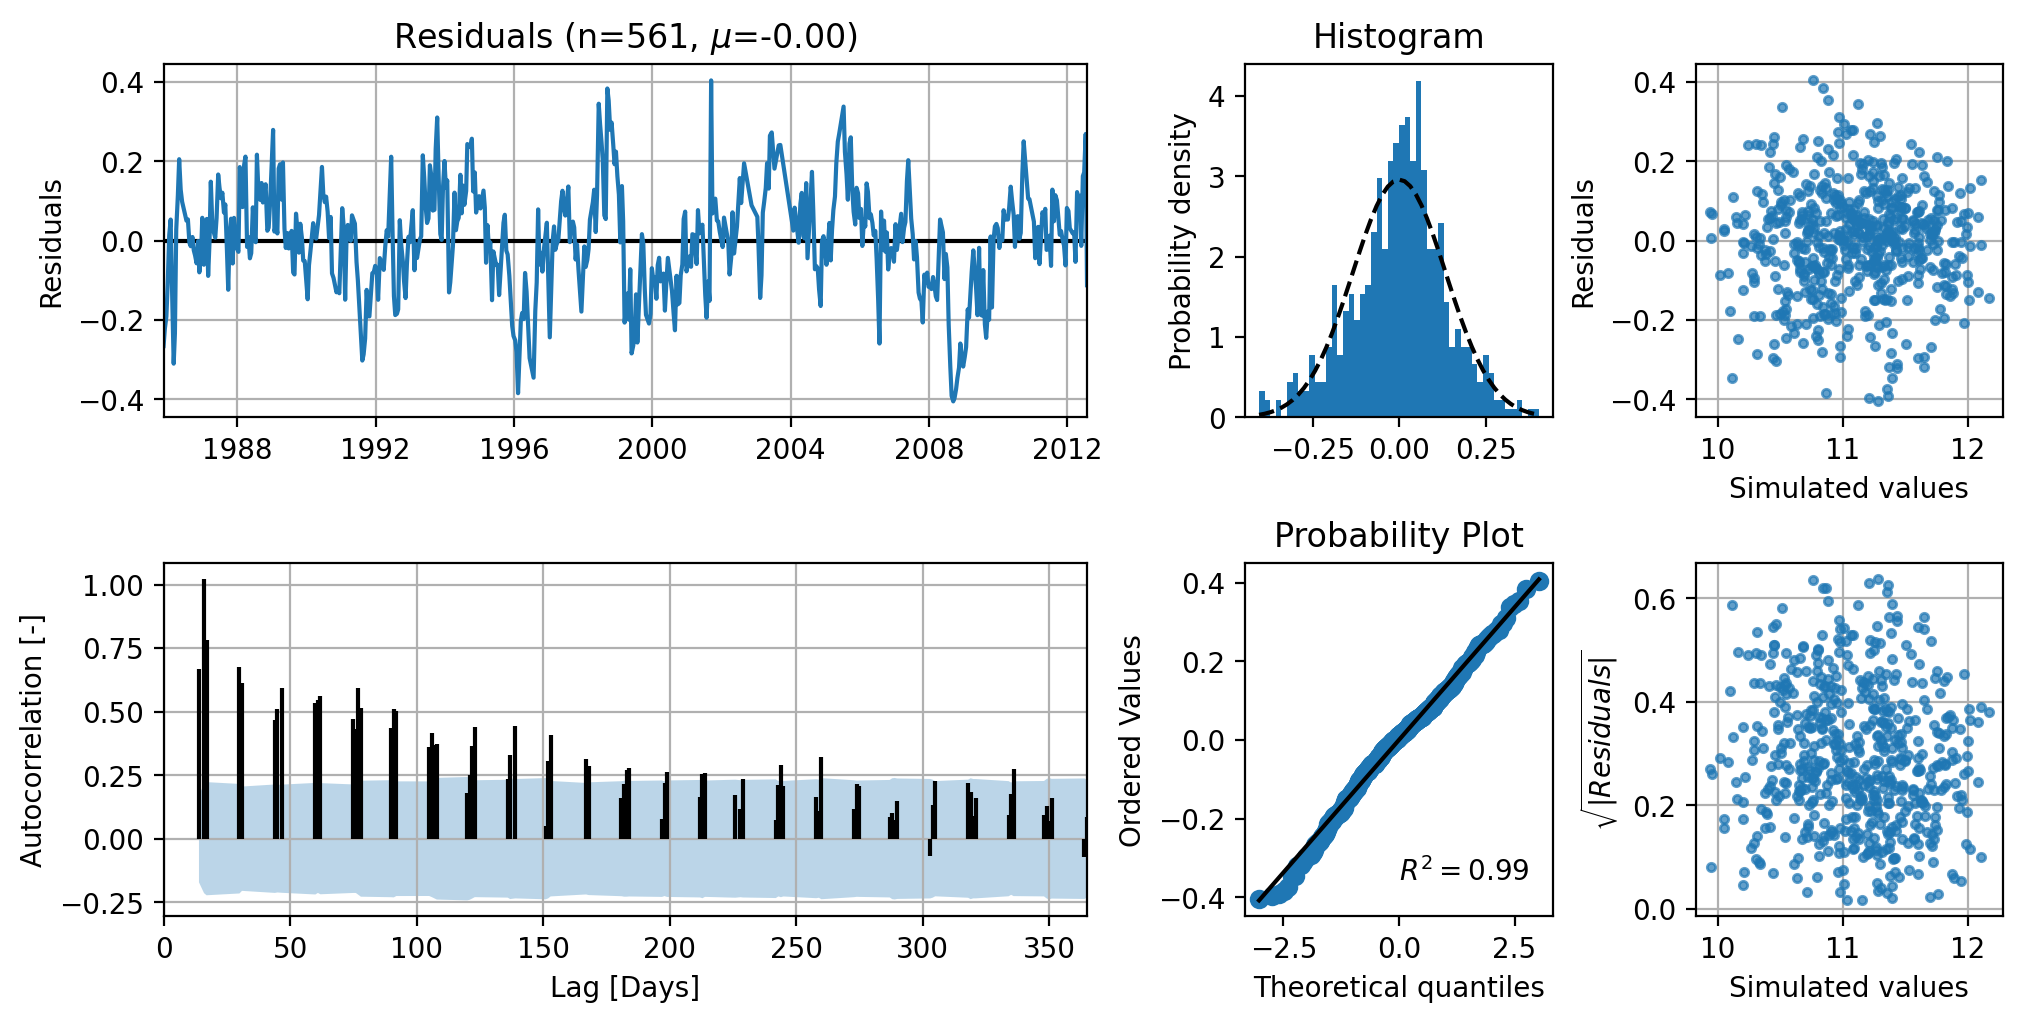

In [13]:
ml2.plots.diagnostics();

In the top-left figure, the noise is shown. It can be seen that there is no clear trend and that the mean value ($\mu$) is equal to 0.00. In the bottom-left figure, the autocorrelation of the lag is displayed with the corresponding 95% confidence interval. For this, 95% of the autocorrelation values should lie within this interval. 
The top-right figure shows the noise as a distribution, with a normal distribution fitted to the noise. This figure can be used to assess whether the noise follows a normal distribution. The bottom-right figure can also be used to test for normality. In this case, the noise satisfies the assumption of normal distribution well.


### Predicting the Groundwater Head

Now that the time series model has been established, it can be used to predict the effect of reducing the abstraction.

For this, the response function of the abstraction is examined. This is shown in the figure below. The bandwidth of the response function is also shown, with a 95% confidence interval. This was determined using Monte Carlo sampling based on the results of the time series analysis. The response function stabilizes after approximately 6000 days. The "gain" (the level at which the response function stabilizes) of the response function is approximately -0.00014 m (-0.14 mm), which represents the decrease in head resulting from a permanent abstraction of 1 m³/day. For a constant abstraction of, for example, 1000 m³/day, the groundwater head is expected to decline by approximately 0.14 meters.


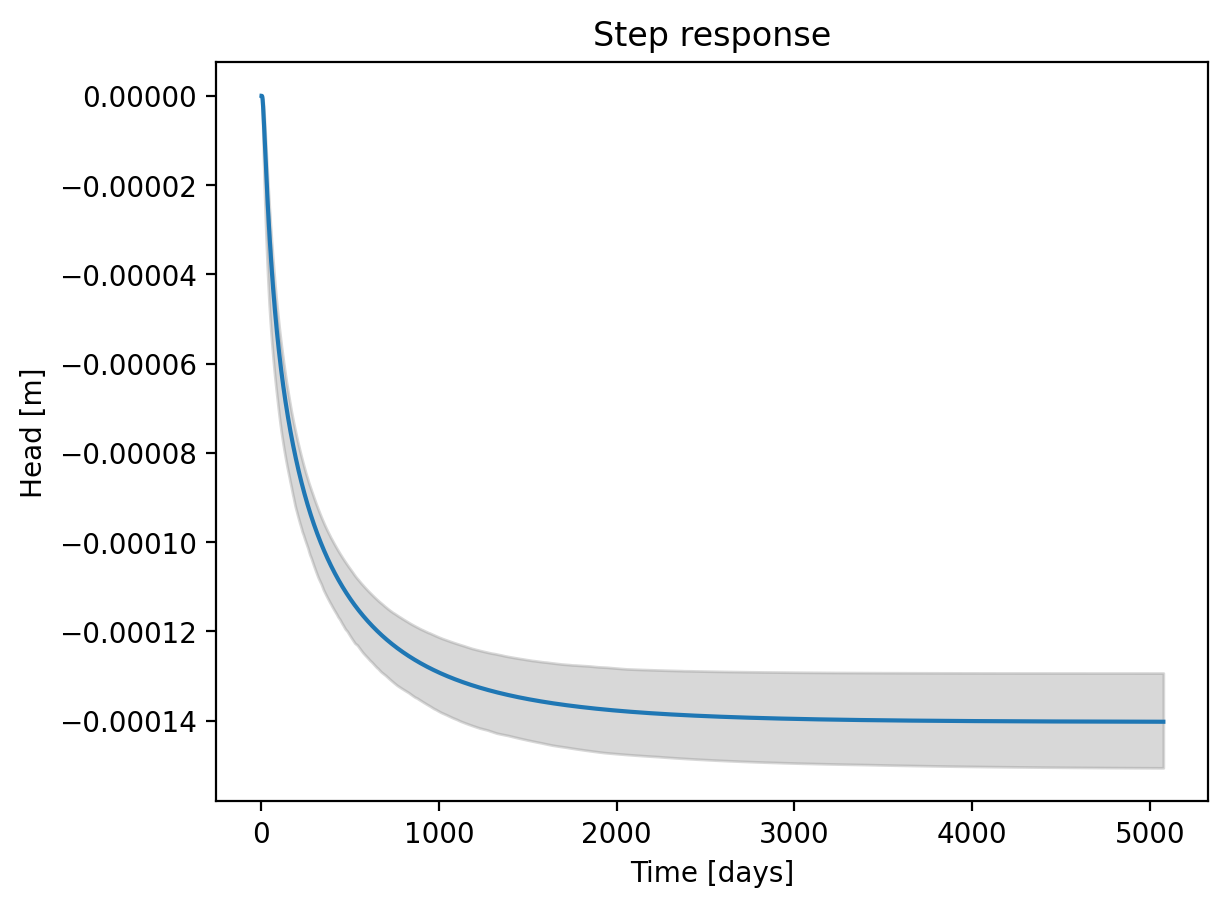

In [14]:
fig, ax = plt.subplots()
step = ml2.get_step_response('abstraction')
ci_step = ml2.fit.ci_step_response('abstraction')
ax.plot(step)
ax.fill_between(x=ci_step.index,
                y1=ci_step[0.025], y2=ci_step[0.975], color='gray', alpha=0.3)

# figuur opmaken
ax.set_xlabel('Time [days]')
ax.set_ylabel('Head [m]')
ax.set_title('Step response');

Using this response function, the expected rise in groundwater head resulting from stopping the abstraction can be predicted. The average abstraction for the period up to 2012-08-01 was 7171 m³/day. The response due to the change from an average of 7171 m³/day to 0 m³/day is shown in the figure below. In this figure, the response as determined by the time series model is scaled to the average abstraction.

The expected average rise in groundwater head is between 0.75 and 1.18 meters, with the effect of the abstraction having dissipated after approximately 5700 days.


Text(0.5, 1.0, 'Step response')

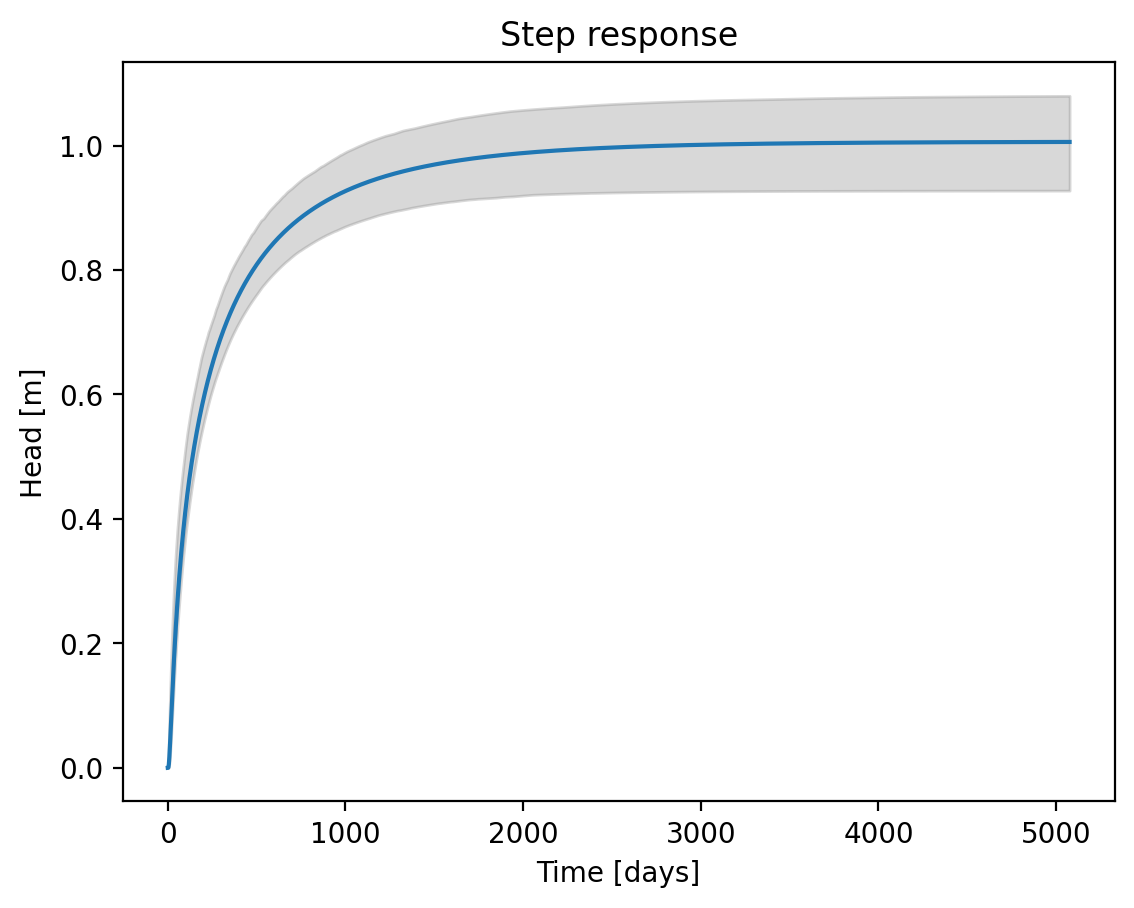

In [15]:
fig, ax = plt.subplots()

# Calculate the average abstraction (excluding zero values)
average_abstraction = abstraction[abstraction != 0].mean().values

# Plot the scaled step response
ax.plot(step * -average_abstraction)

# Add confidence interval shading
ax.fill_between(
    x=ci_step.index,
    y1=ci_step[0.025] * -average_abstraction,
    y2=ci_step[0.975] * -average_abstraction,
    color='gray',
    alpha=0.3
)

# Extract the expected final response and confidence bounds
expected = step.iloc[-1] * -average_abstraction
upper_bound = ci_step[0.025].iloc[-1] * -average_abstraction
lower_bound = ci_step[0.975].iloc[-1] * -average_abstraction



ax.set_xlabel('Time [days]')
ax.set_ylabel('Head [m]')
ax.set_title('Step response')

### Verification of the Prediction

A few years later, the water board decides to assess whether the prediction made by the consultancy regarding the groundwater head has come true. For this, the most recent measurements of the groundwater level are used. The full time series is shown in the figure below. It can be seen that the groundwater level appears to have increased since 2012.

The figure also shows the simulation in which the most recent data for precipitation and evaporation has been used. The same time series model was used as the one originally developed for making the prediction.

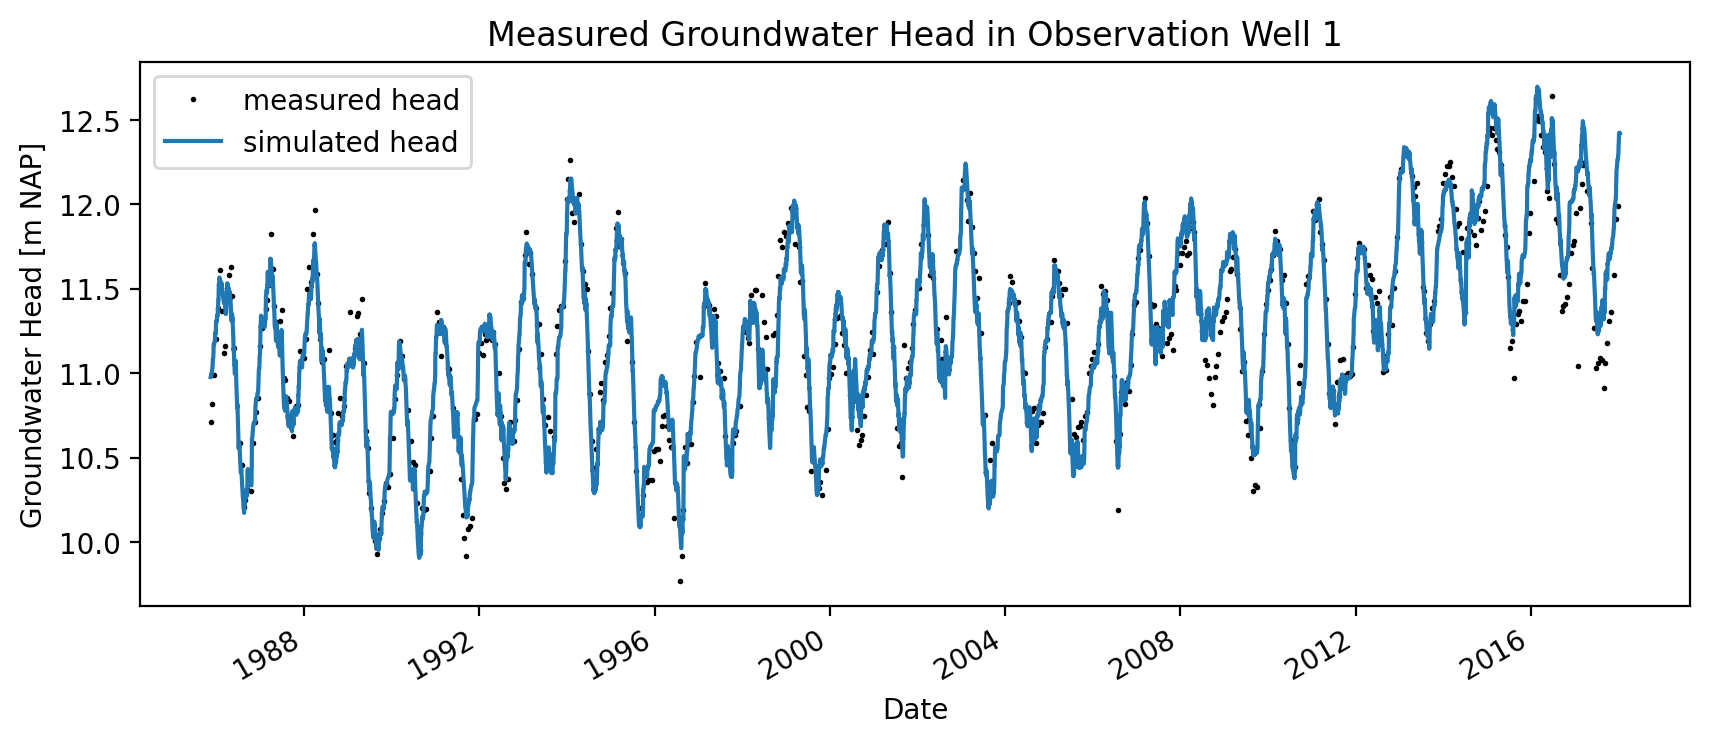

In [16]:
# plotten van de stijghoogte
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws_cleaned[gws_cleaned < mv].plot(ax=ax, color='k', ls='', marker='.', markersize=2)
ml2_sim.plot(ax=ax, color='C0')


ax.set_ylabel('Groundwater Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head in Observation Well 1')
ax.legend(['measured head', 'simulated head'])


A new time series model is developed using the most recent data. The measurement series for precipitation, evaporation, and abstraction have been updated. The same response functions as in the previous analysis are chosen for the explanatory series.

In [17]:
ml2 = ps.Model(gws_cleaned[gws_cleaned < mv])

sm1 = ps.RechargeModel(precipitation, evaporation, rfunc=ps.Gamma(), name='gwa')


sm2 = ps.StressModel(stress=abstraction, rfunc=ps.Hantush(),
                     name='abstraction', settings='well', up=False)
ml2.add_stressmodel([sm1, sm2])

ml2.solve(report=False)

The simulation of the time series model using the full measurement series is shown in the figure below. Additionally, the contributions of the different explanatory series are displayed. For the abstraction, it can be seen that its contribution decreases after 2012 (when the abstraction is stopped). It is also clearly visible that the effect gradually dissipates and does not occur instantaneously.

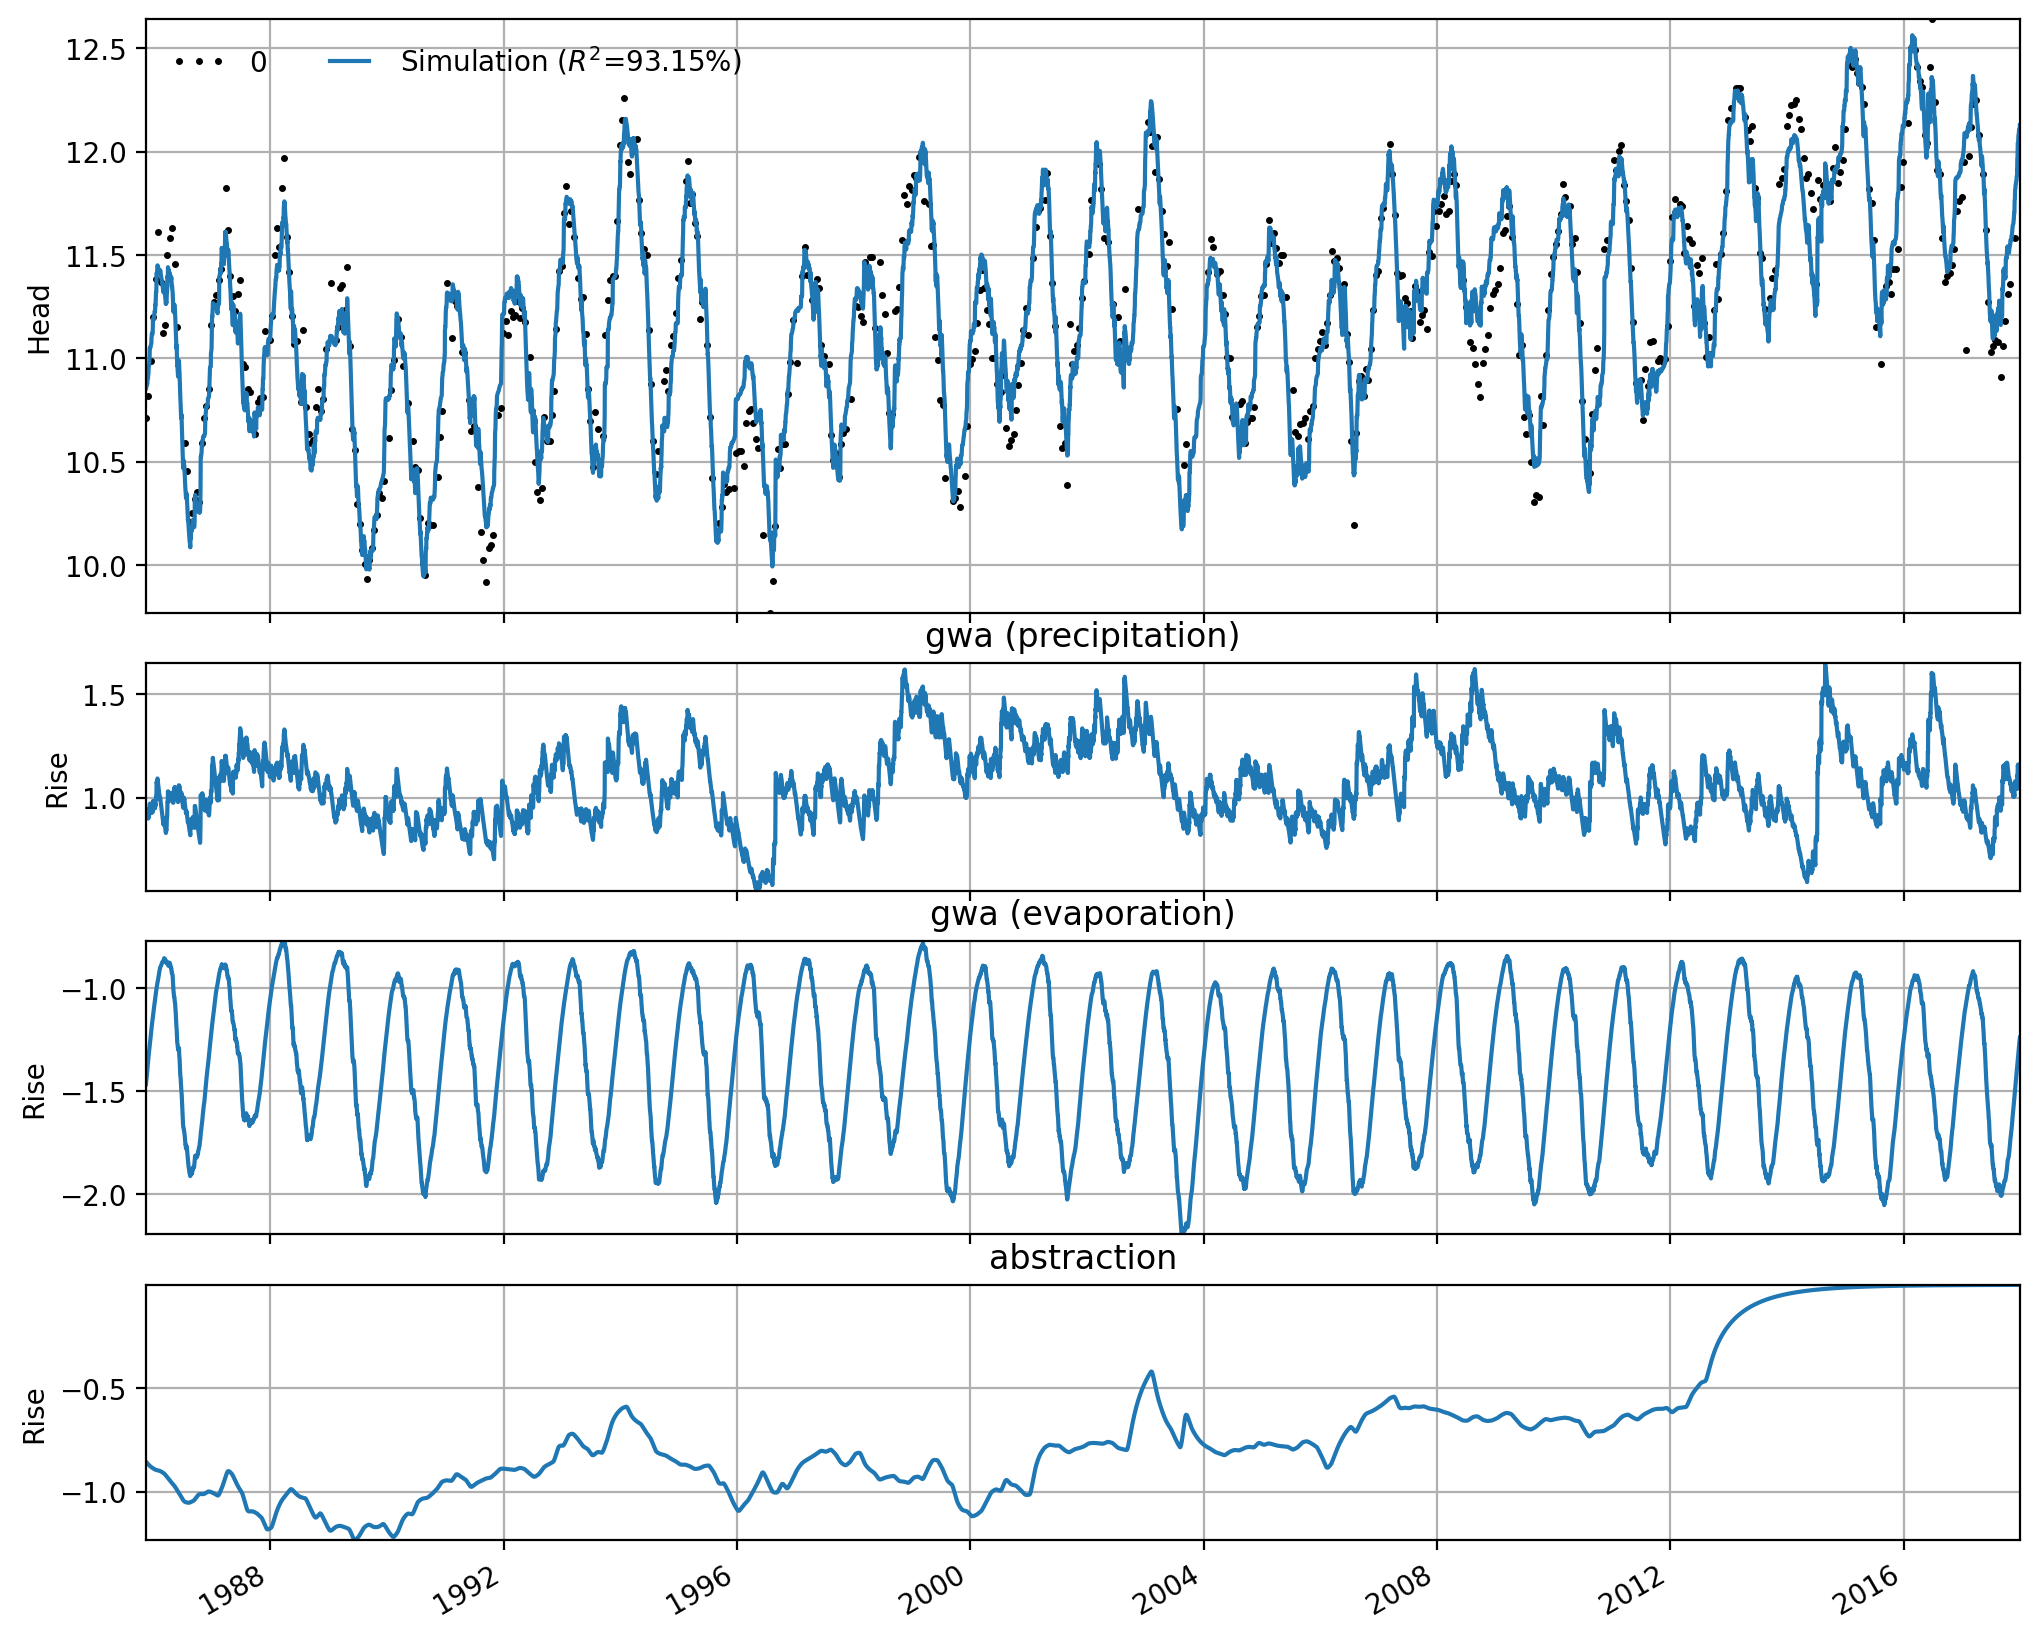

In [18]:
ml2.plots.decomposition(figsize=(10, 8));

The step responses of both models are shown in the figure below. It can be seen that the response functions differ. With the new response function, the range of the average effect of stopping the abstraction lies between 0.76 and 0.93 meters, compared to a range between 0.75 and 1.18 meters from the previous time series model (for an abstraction of 7171 m³/day). Additionally, according to the new time series model, the effect of the abstraction diminishes more quickly.

The figure below shows that the response determined using the new time series model falls within the confidence band of the old model. The range of the new response also lies within the range of the previous time series model.

These results indicate that the prediction of the rise in groundwater head due to stopping the abstraction is consistent with the current measurements. With the new time series model, the uncertainty in the response has been reduced.

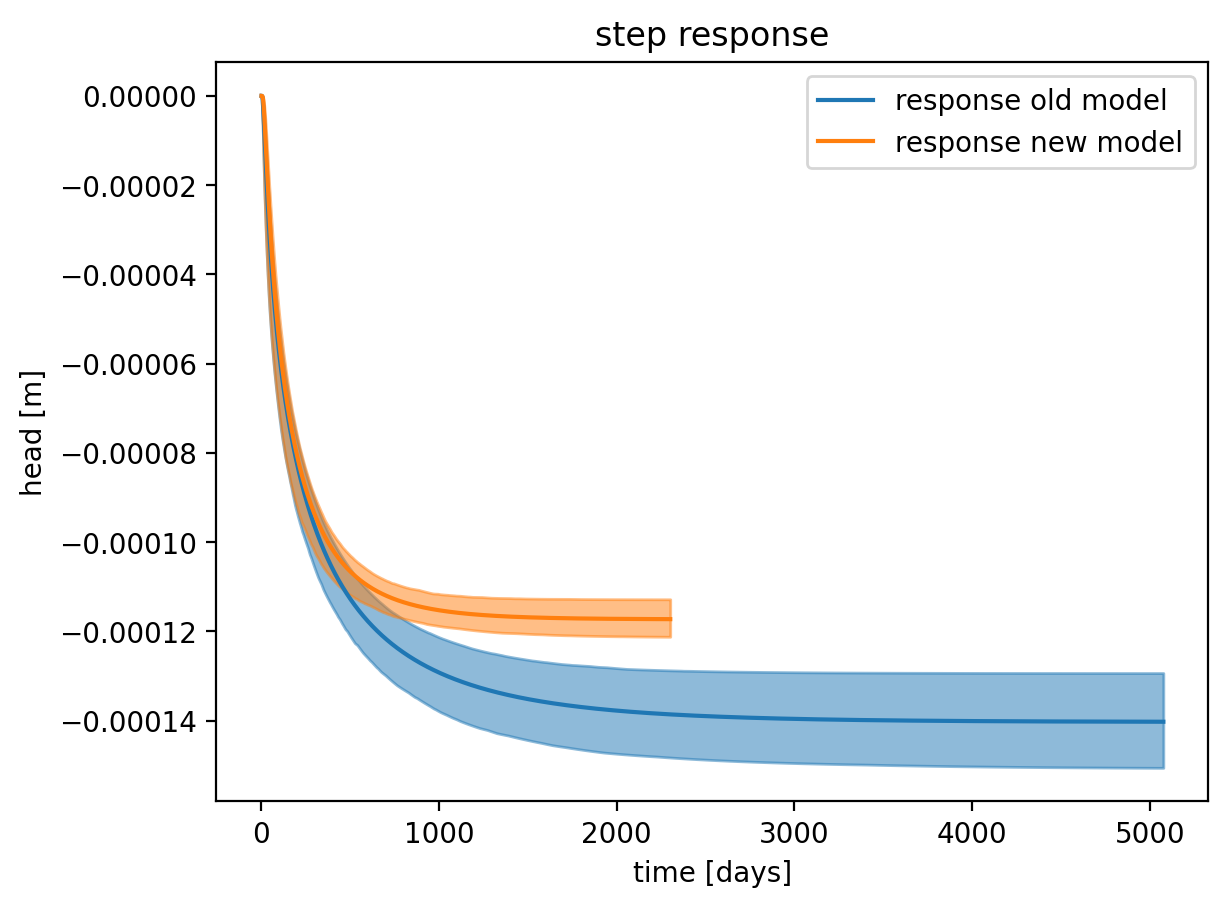

In [19]:
fig, ax = plt.subplots()

# Get the step response and confidence interval for the new model
step_new = ml2.get_step_response('abstraction')
ci_step_new = ml2.fit.ci_step_response('abstraction')

# Plot the old and new step responses
ax.plot(step)
ax.plot(step_new)

# Add confidence intervals for both models
ax.fill_between(x=ci_step.index,
                y1=ci_step[0.025], y2=ci_step[0.975], color='C0', alpha=0.5)
ax.fill_between(x=ci_step_new.index,
                y1=ci_step_new[0.025], y2=ci_step_new[0.975], color='C1', alpha=0.5)

# Compute expected effect and bounds for the new response
expected_new = step_new.iloc[-1] * average_abstraction
lower_bound_new = ci_step_new[0.025].iloc[-1] * -average_abstraction
upper_bound_new = ci_step_new[0.975].iloc[-1] * -average_abstraction

# Format the figure
ax.set_xlabel('time [days]')
ax.set_ylabel('head [m]')
ax.set_title('step response')
ax.legend(['response old model', 'response new model'])


## Part II: Groundwater Head Recovery in April

In a nature reserve, the groundwater level has been measured for years in observation well PB01. In recent years (2018 and 2019), the water board has noticed that the groundwater level during the summer period is lower than average. This was also the case during the most recent measurements in August 2019. The hydrologist at the water board has been asked to provide an estimate of the groundwater level at the start of the new growing season in April of the following year (April 2020).

Based on a time series analysis, the expected groundwater level is assessed for a "wet," "dry," and "average" winter period (from September to April). In this way, the water board hopes to gain insight into the recovery of the groundwater head under different conditions.

### Available Data Example 2

The figure below shows the measurement series from observation well PB01. The series spans from 1985 to September 2019. The variation in groundwater level is approximately 2 meters. It can be seen from the series that the groundwater head during the summers of 2018 and 2019 was relatively low due to the relatively dry periods.

Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.

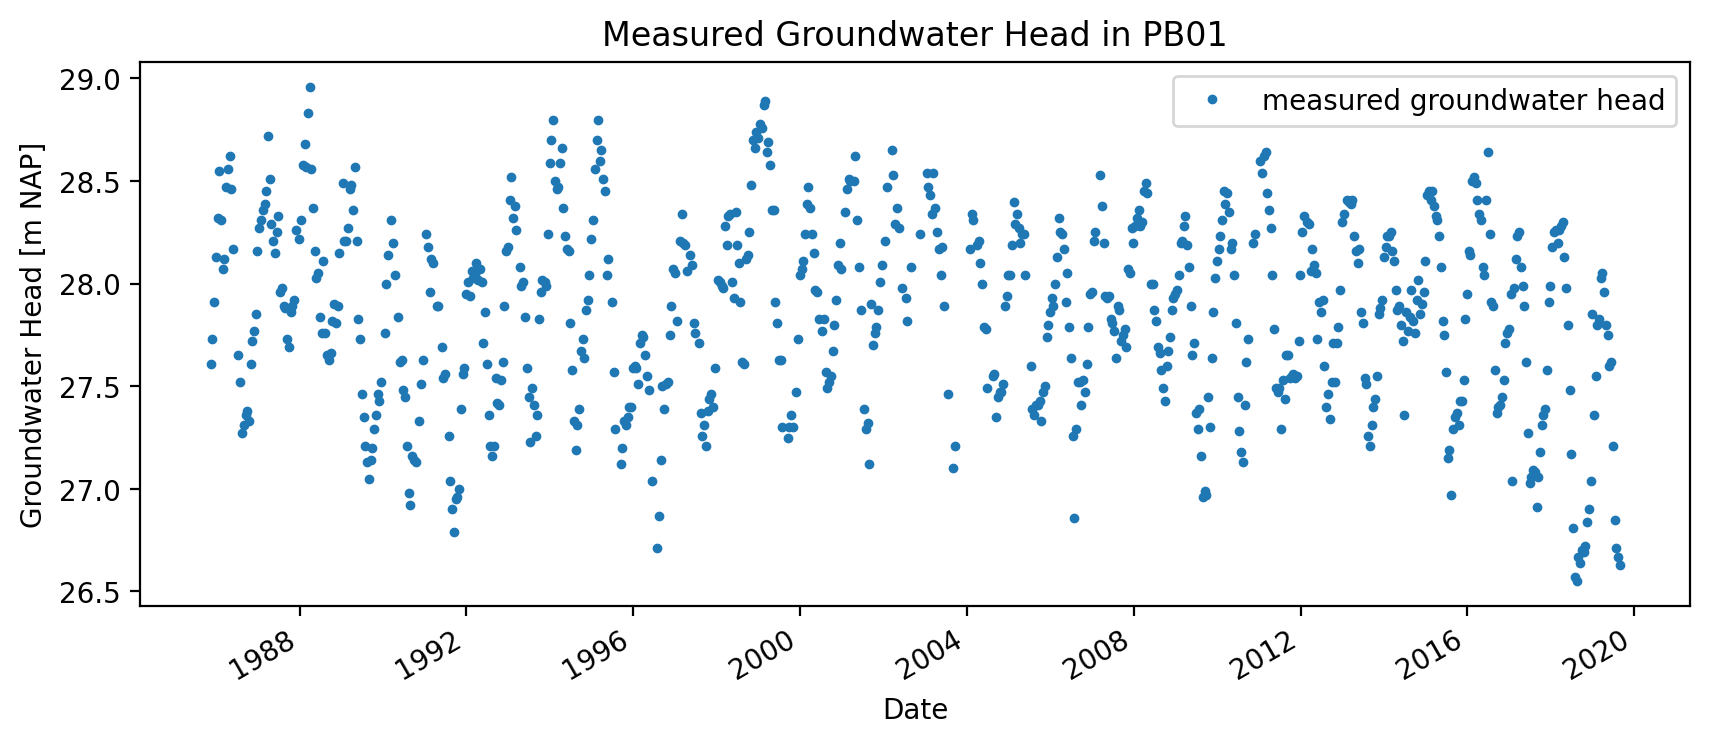

In [20]:

gws = pd.read_csv('data/PB01.csv', skiprows=16, index_col=2, parse_dates=True).iloc[:, 4]/100



fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws[:'2019-09-01'].plot(ax=ax, color='C0', ls='', marker='.', markersize=5)


ax.set_ylabel('Groundwater Head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head in PB01')
ax.legend(['measured groundwater head'])


The precipitation and evaporation data near PB01 were collected from the nearest KNMI weather station. The precipitation and evaporation are shown in the graph below. The weather station contains data from 1965 up to and including September 2019.

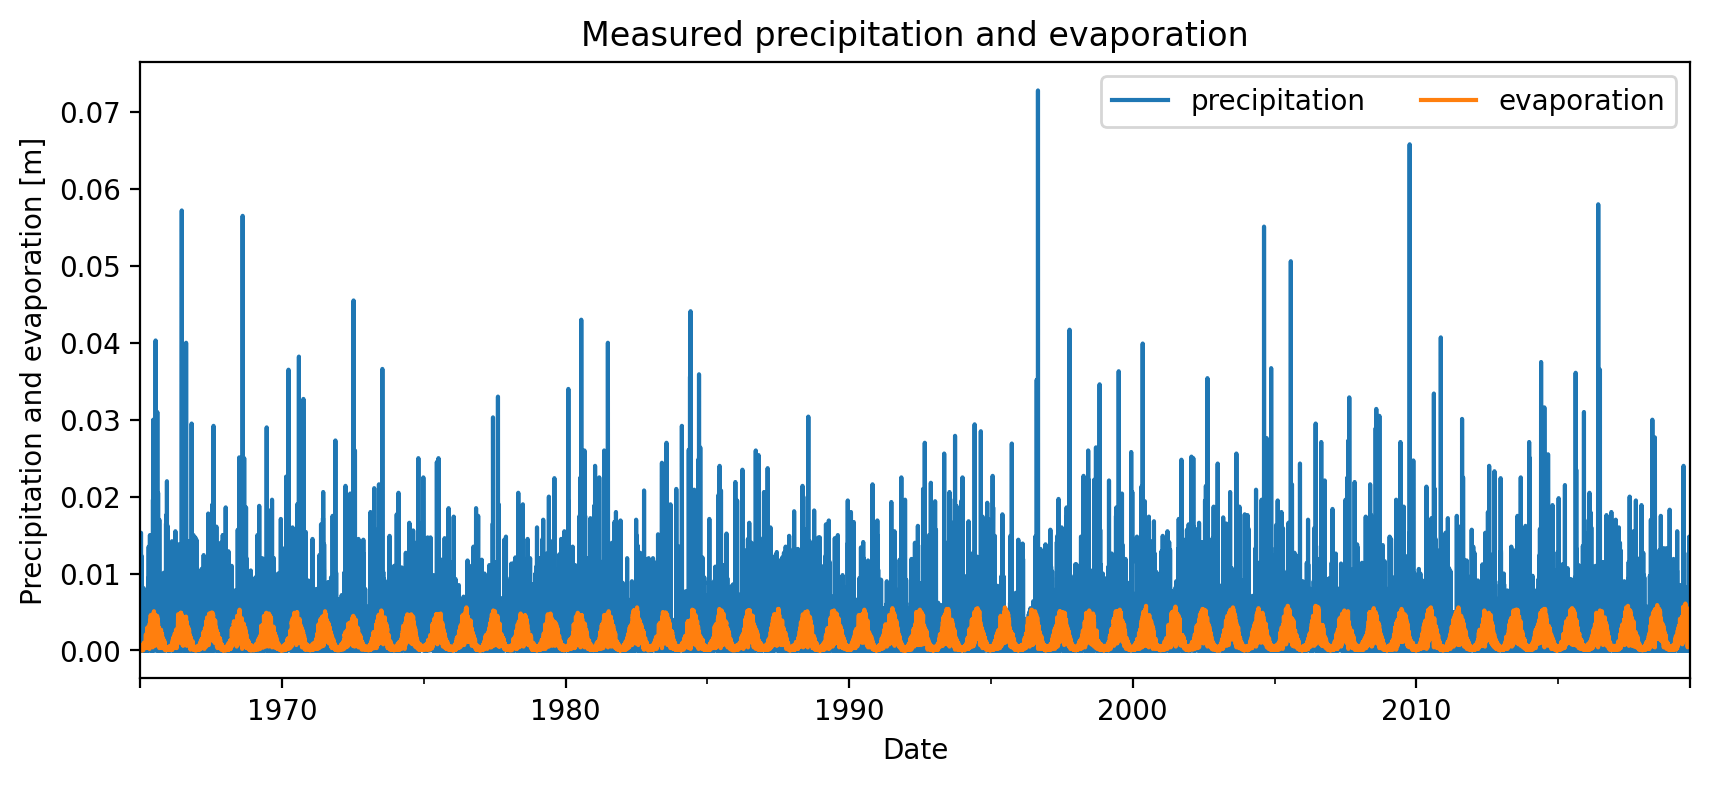

In [21]:
precipitation = pd.read_csv('data/neerslag.csv', index_col=0, parse_dates=True)
evaporation = pd.read_csv('data/verdamping.csv', index_col=0, parse_dates=True)


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
precipitation[:'2019-09-01'].plot(ax=ax, color='C0')
evaporation[:'2019-09-01'].plot(ax=ax, color='C1')


ax.set_ylabel('Precipitation and evaporation [m]')
ax.set_xlabel('Date')
ax.set_title('Measured precipitation and evaporation')
ax.legend(['precipitation', 'evaporation'], ncol=2)


### Setting Up the Time Series Model

A time series model is developed based on the measurement series from PB01. Precipitation and evaporation are used as explanatory series. For both precipitation and evaporation, the Gamma response function is selected in the time series analysis.

In [22]:
# opzetten model
ml = ps.Model(gws[:'2019-09-01'])

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(precipitation, evaporation, rfunc=ps.Gamma(), name='gwa')
ml.add_stressmodel(sm1)

# oplossen van het tijdreeksmodel
ml.solve(report=False)

The time series model has an R² of 0.92. In the figure below, the simulation of the time series model is shown along with the groundwater head measurements. The variation in groundwater head appears to be well explained using precipitation and evaporation. The time series model was simulated up to September 1, 2019.

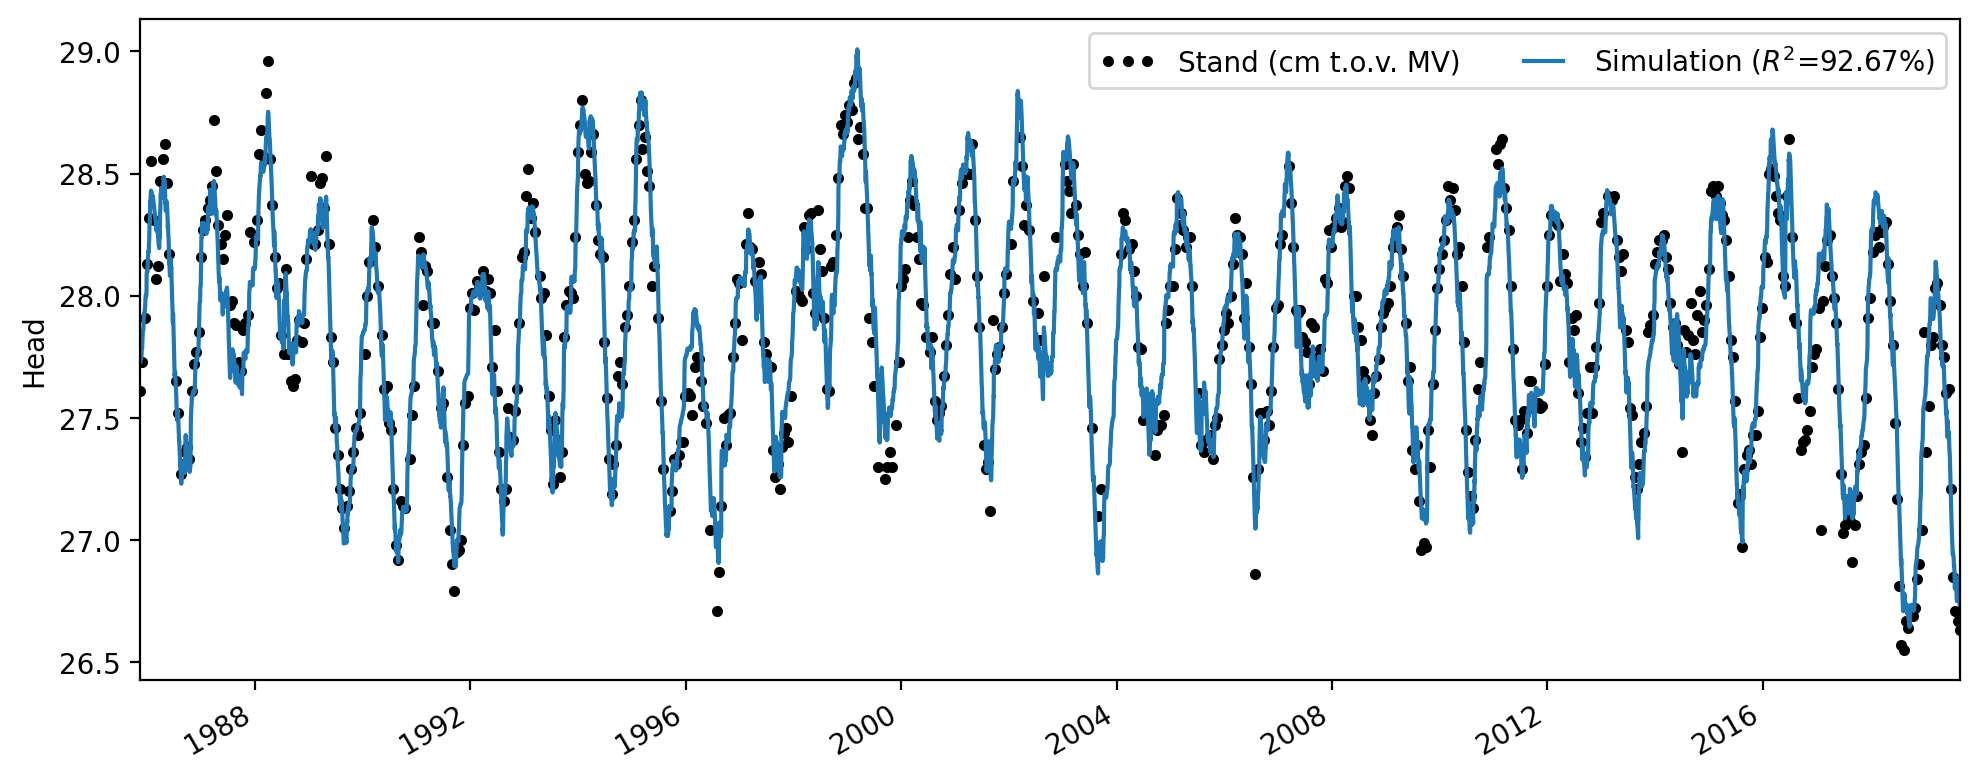

In [23]:
ml.plot(figsize=(10, 4));

### Precipitation Surplus Prediction

To estimate the groundwater head resulting from a "wet," "dry," and "average" winter period, the precipitation surplus over the past 30 years is analyzed.

The precipitation surplus is calculated based on precipitation, evaporation, and the evaporation factor. When using the evaporation factor, the uncertainty of these parameters is not included in the analysis, and therefore the uncertainty of the estimated precipitation surplus is also not taken into account. The figures below show the precipitation surpluses over the past 30 years, with the years 2018 and 2019 highlighted. The assumption in calculating these surpluses is that the relationship between precipitation, evaporation, and groundwater recharge has not changed, and that this relationship remains the same in both dry and wet years.

The overview shows that, for the period September–April, the precipitation surplus in 2018 was among the lowest in the past 30 years.

For the "wet" year, the 95% upper bound of the precipitation surplus is used. For the dry year, the 5% lower bound is applied. The "average" year is based on the mean precipitation surplus. These scenarios are calculated based on the daily precipitation surplus, where the 95%, 5%, or average value of the surplus is determined for each day. The resulting range is shown in the figure below.

([<matplotlib.axis.XTick at 0x12746c390>,
 [Text(0, 0, 'September'),
  Text(30, 0, 'October'),
  Text(61, 0, 'November'),
  Text(91, 0, 'December'),
  Text(122, 0, 'January'),
  Text(153, 0, 'February'),
  Text(181, 0, 'March'),
  Text(212, 0, 'April')])

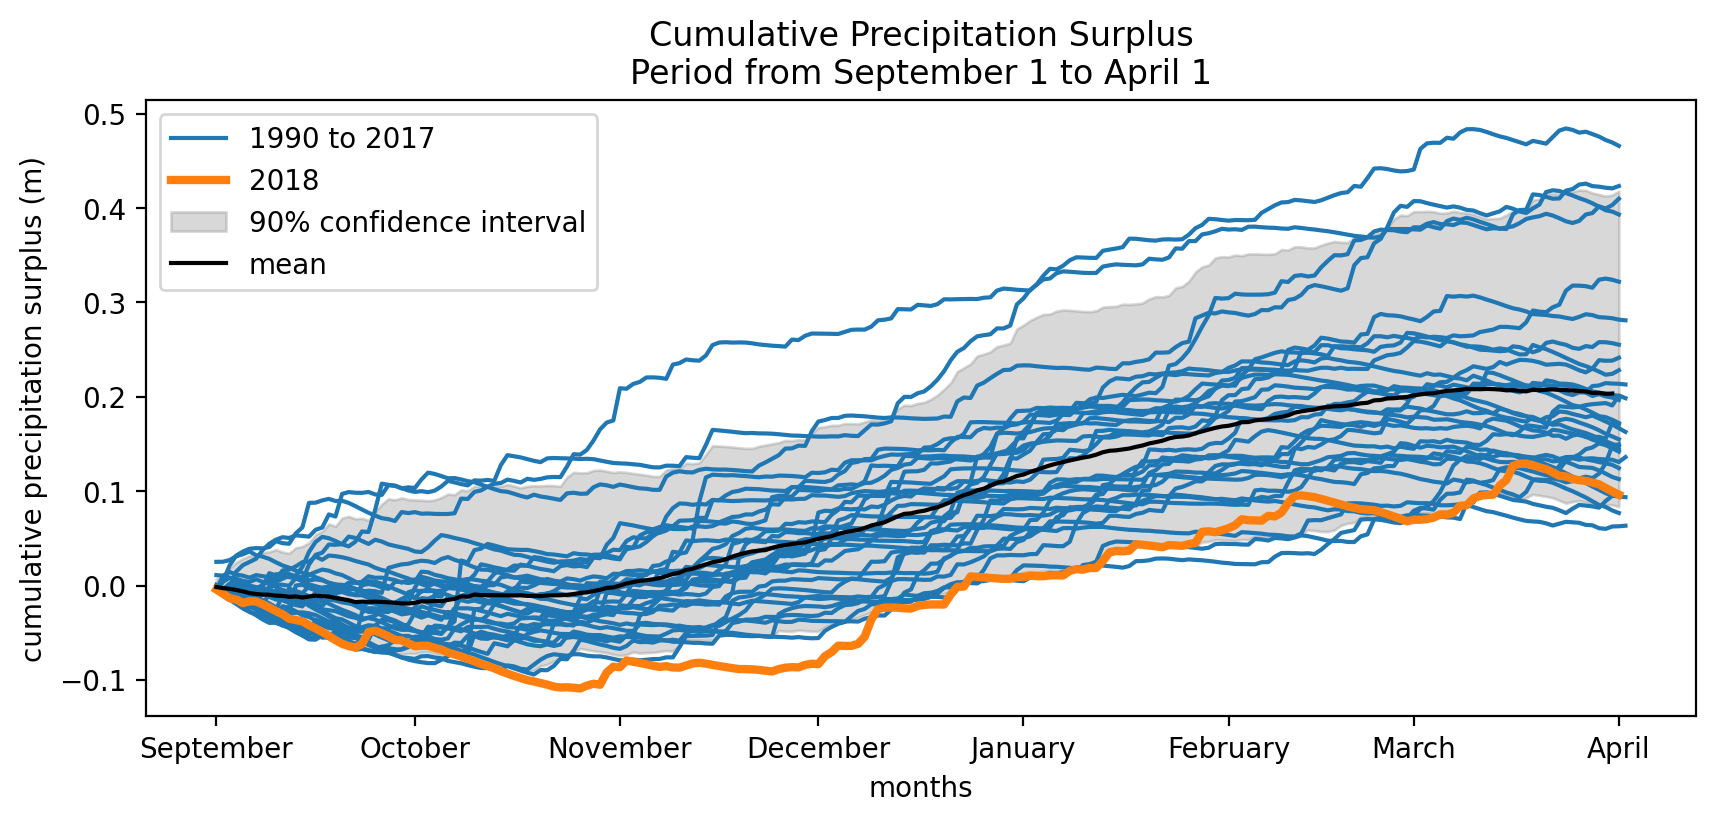

In [24]:
plt.figure(figsize=(10, 4))

surplus = pd.DataFrame()
evap_factor = ml.parameters.loc['gwa_f', 'optimal']

for year in range(1990, 2019):
    y = (precipitation[f'{year}-09-01':f'{year+1}-04-01'] +
         evap_factor * evaporation[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))

    if year == 1990:
        plt.plot(x, y, color='C0', label='1990 to 2017')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    elif year == 2018:
        plt.plot(x, y, color='C1', label='2018', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    else:
        plt.plot(x, y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)

    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    surplus = pd.concat([surplus, y], axis=1)

# Calculate quantiles and mean across all years
upper_bound = surplus.quantile(0.95, axis=1)
lower_bound = surplus.quantile(0.05, axis=1)
mean_surplus = surplus.mean(axis=1)

# Remove leap day if present
surplus = surplus.drop(index='2-29')
upper_bound = upper_bound.drop(index='2-29')
lower_bound = lower_bound.drop(index='2-29')
mean_surplus = mean_surplus.drop(index='2-29')

# Plot confidence interval and mean
plt.fill_between(x=x, y1=lower_bound.values, y2=upper_bound.values,
                 color='gray', alpha=0.3, label='90% confidence interval')
plt.plot(x[:-1], mean_surplus[:-1], color='k', label='mean')
plt.xlabel('months')
plt.ylabel('cumulative precipitation surplus (m)')
plt.legend()
plt.title('Cumulative Precipitation Surplus\nPeriod from September 1 to April 1')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]),
           labels=['September', 'October', 'November', 'December', 'January', 'February', 'March', 'April'])


### Predicting Groundwater Head

For the three scenarios, the groundwater head on April 1, 2020 is determined using the results of the time series model. It is assumed that the system does not change, the response remains the same, and no additional influences on the groundwater head occur during the simulation period.

Using the response function from the time series model, the development of the groundwater head from September 1, 2019 to April 1, 2020 is calculated. The figure below shows the groundwater head predictions for the three scenarios. These provide three estimates of the groundwater level for the period leading up to April 1, 2020. With these predictions, it is possible to assess whether the groundwater head recovers after a dry period under a "dry," "wet," or "average" winter season.

(17987.0, 18362.0)

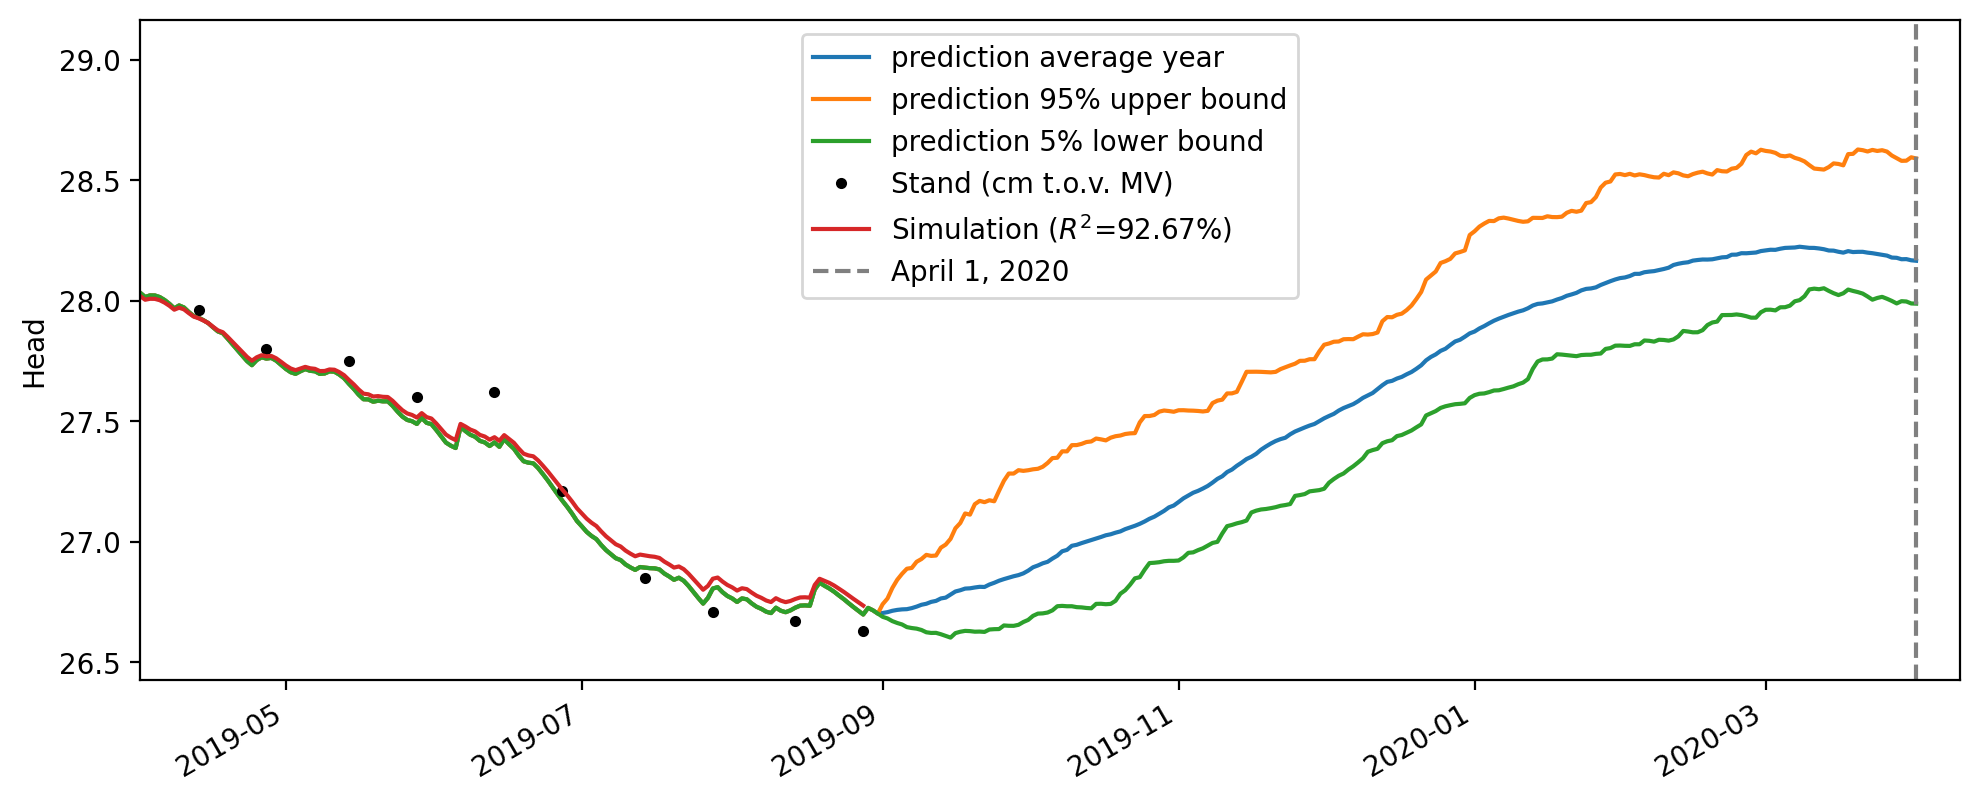

In [25]:
# Set up simulation model
ml_sim = ml.copy()

fig, ax = plt.subplots(figsize=(10, 4))

# ----------------------------
# Average scenario
# ----------------------------
# Assign the index for the forecast period
mean_surplus.index = pd.date_range('2019-09-01', '2020-03-31')

# Calculate stress before the forecast period (until 2019-08-31)
mean_stress_past = precipitation[:'2019-08-31'].squeeze() + evap_factor * evaporation[:'2019-08-31'].squeeze()

# Calculate the forecast stress based on the daily difference in cumulative surplus
mean_forecast = mean_surplus.diff().fillna(mean_surplus).squeeze()

# Combine the past and forecast into one complete stress series
mean_stress = pd.concat([mean_stress_past, mean_forecast])


ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=mean_stress,  # <- adjust if needed
                        rfunc=ps.Exponential(),
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a', 'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A', 'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

mean_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(mean_sim, label='prediction average year')


upper_bound.index = pd.date_range('2019-09-01', '2020-03-31')
upper_stress_past = precipitation[:'2019-08-31'].squeeze() + evap_factor * evaporation[:'2019-08-31'].squeeze()
upper_forecast = upper_bound.diff().fillna(upper_bound).squeeze()
upper_stress = pd.concat([upper_stress_past, upper_forecast])


ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=upper_stress,  # <- adjust if needed
                        rfunc=ps.Exponential(),
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a', 'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A', 'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

upper_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(upper_sim, label='prediction 95% upper bound')


lower_bound.index = pd.date_range('2019-09-01', '2020-03-31')
lower_stress_past = precipitation[:'2019-08-31'].squeeze() + evap_factor * evaporation[:'2019-08-31'].squeeze()
lower_forecast = lower_bound.diff().fillna(lower_bound).squeeze()
lower_stress = pd.concat([lower_stress_past, lower_forecast])


ml_sim.del_stressmodel('gwa')
sm_sim = ps.StressModel(stress=lower_stress,  # <- adjust if needed
                        rfunc=ps.Exponential(),
                        name='gwa',
                        settings='prec')
ml_sim.add_stressmodel(sm_sim)
ml_sim.parameters.loc['gwa_a', 'optimal'] = ml.parameters.loc['gwa_a', 'optimal']
ml_sim.parameters.loc['gwa_A', 'optimal'] = ml.parameters.loc['gwa_A', 'optimal']

lower_sim = ml_sim.simulate(tmax='2020-04-01')
ax.plot(lower_sim, label='prediction 5% lower bound')


ml.plot(ax=ax)
ax.axvline('2020-04-01', color='gray', ls='--', label='April 1, 2020')
ax.legend()
ax.set_xlim(xmin=pd.Timestamp('2019-04-01'), xmax=pd.Timestamp('2020-04-10'))


After April 1, 2020, the water board collected the most recent data from observation well PB01. These can be compared with the prediction made in September. In the figure below, the actual measured groundwater heads are shown together with the prediction.

The measured groundwater head during the September–October period is lower than the average scenario. From March 2020 onward, the measured groundwater head is higher than the average scenario. Overall, the measurements fall within the range of the three scenarios.

(17987.0, 18362.0)

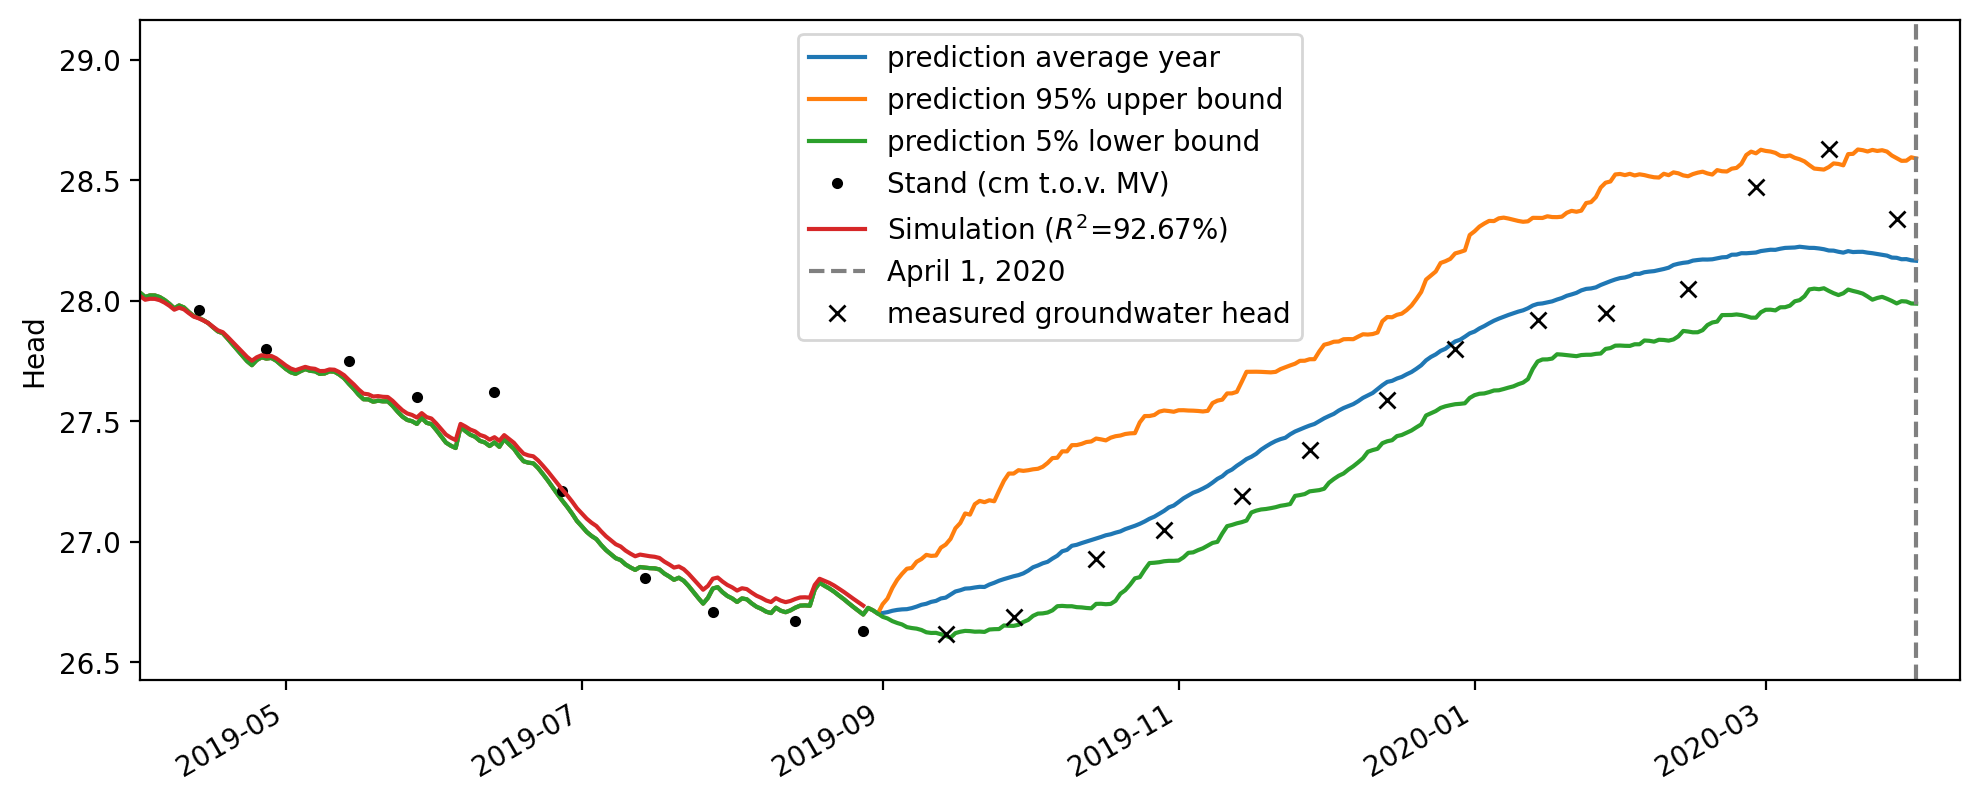

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

# Plot the simulated groundwater head for the three scenarios
ax.plot(mean_sim, label='prediction average year')
ax.plot(upper_sim, label='prediction 95% upper bound')
ax.plot(lower_sim, label='prediction 5% lower bound')

# Plot the original model
ml.plot(ax=ax)

# Mark April 1, 2020
ax.axvline('2020-04-01', color='gray', ls='--', label='April 1, 2020')

# Plot the measured groundwater head from September 2019 to April 2020
ax.plot(gws['2019-09-01':'2020-04-10'], marker='x', ls='', color='k', label='measured groundwater head')

ax.legend()
ax.set_xlim(xmin=pd.Timestamp('2019-04-01'), xmax=pd.Timestamp('2020-04-10'))

In the figure below, the precipitation surplus for the period September 2019 – April 2020 is compared with the surpluses of previous years. This precipitation surplus was calculated in the same way as for the other years. It can be seen that for this year, the surplus in September–October was lower than average, and in March–April it was higher. This pattern is consistent with the comparison between the measurements and the three scenarios.

([<matplotlib.axis.XTick at 0x12a04c990>,
 [Text(0, 0, 'September'),
  Text(30, 0, 'October'),
  Text(61, 0, 'November'),
  Text(91, 0, 'December'),
  Text(122, 0, 'January'),
  Text(153, 0, 'February'),
  Text(181, 0, 'March'),
  Text(212, 0, 'April')])

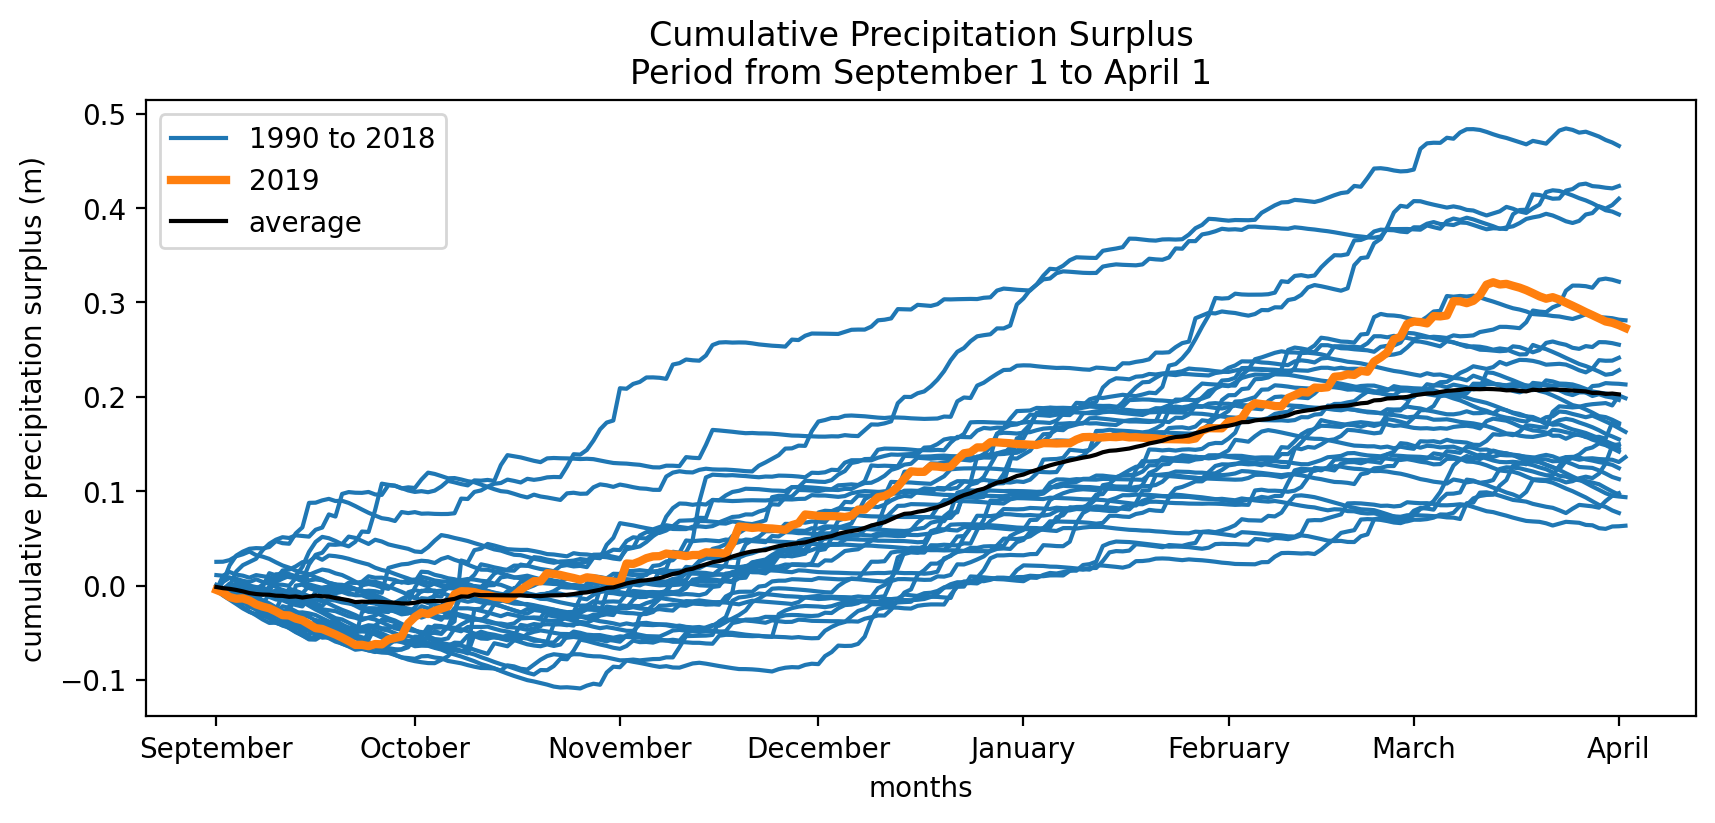

In [27]:
plt.figure(figsize=(10, 4))

evap_factor = ml.parameters.loc['gwa_f', 'optimal']

for year in range(1990, 2020):
    y = (precipitation[f'{year}-09-01':f'{year+1}-04-01'] +
         evap_factor * evaporation[f'{year}-09-01':f'{year+1}-04-01'])
    y = y.cumsum()
    x = np.arange(len(y))

    if year == 1990:
        plt.plot(x, y, color='C0', label='1990 to 2018')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    elif year == 2019:
        plt.plot(x, y, color='C1', label='2019', lw=3)
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)
    else:
        plt.plot(x, y, color='C0')
        dt_max = y.idxmax() - datetime.datetime(year, 9, 1)

    y.columns = [str(year)]
    y.index = y.index.month.astype(str) + '-' + y.index.day.astype(str)
    surplus = pd.concat([surplus, y], axis=1)

# Optional: fill between bounds (commented out)
# plt.fill_between(x=x, y1=lower_bound.values, y2=upper_bound.values, 
#                  color='gray', alpha=0.3, label='90% confidence interval')

plt.plot(x[:-1], mean_surplus, color='k', label='average')
plt.xlabel('months')
plt.ylabel('cumulative precipitation surplus (m)')
plt.legend()
plt.title('Cumulative Precipitation Surplus\nPeriod from September 1 to April 1')
plt.xticks(np.cumsum([0, 30, 31, 30, 31, 31, 28, 31]),
           labels=['September', 'October', 'November', 'December', 'January',
                   'February', 'March', 'April'])